# Title: Airplane Crashes

In [224]:
#Packages needed for this project
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import datetime
import time
import re
import math
from collections import Counter
from geopy.geocoders import Nominatim
from scipy import interp
from itertools import cycle
from mpl_toolkits.basemap import Basemap

from sklearn.linear_model import LinearRegression, Ridge, RidgeCV ,Lasso, LassoCV
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, accuracy_score
from sklearn.metrics import  auc, f1_score, average_precision_score
from sklearn.grid_search import GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, label_binarize
from sklearn.preprocessing import LabelEncoder

plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['axes.edgecolor'] = 'black'
plt.rcParams['axes.linewidth'] = 0.8


#setting up limit to view maximum rows and columns
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 6000)

<div id="toc"></div>

# Loading Data
Loading cleaned data from part2 capstone notebook where all the clearning/munging of each and every columns in the dataset has been handled and then stored into "df_air1_cleaned_01Jan2017.csv".

In [144]:
df=pd.read_csv('df_air1_cleaned_01Jan2017.csv')
df.drop(['Unnamed: 0','level_0','index'],axis=1, inplace=True)

In [145]:
df_all=df[['Date','Ground','Year','Month','Day','latitude','longititude','loccountry','Aboard_num','Fatalities_num','Fatalities_ratio',
          'Survived_num','Survival_ratio','Manufacturer_ac_type','reason_crash']]

In [146]:
print df_all.shape
df_all.head(2)

(4941, 15)


Date  Ground  Year  Month  Day   latitude  longititude  \
0  1921-08-24     1.0  1921      8   24  53.633976    -0.276514   
1  1921-09-06     0.0  1921      9    6  48.856614     2.352222   

       loccountry  Aboard_num  Fatalities_num  Fatalities_ratio  Survived_num  \
0  United Kingdom          46              46               1.0             0   
1          France           5               5               1.0             0   

   Survival_ratio Manufacturer_ac_type  reason_crash  
0             0.0                 None  engine error  
1             0.0                 None          None

In [7]:
print "Mean of Fatalities per accident: ",df_all['Fatalities_num'].mean()
print "Mean ratio of Fatalities ratio : ",df_all['Fatalities_ratio'].mean()

print "Mean of Survival per accident  : ",df_all['Survived_num'].mean()
print "Mean of ratio of Survival ratio: ",df_all['Survival_ratio'].mean()

Mean of Fatalities per accident:  20.2098765432
Mean ratio of Fatalities ratio :  0.825663508195
Mean of Survival per accident  :  8.02165553532
Mean of ratio of Survival ratio:  0.173526939082


## Correlation
Checking correlation of the features. The below features are highly correlated to fatalities ratio, fatalities number, survival number and survival ratio. Some of them are negatively correlated as well
- Ground
- Year, month
- latitude and longitude

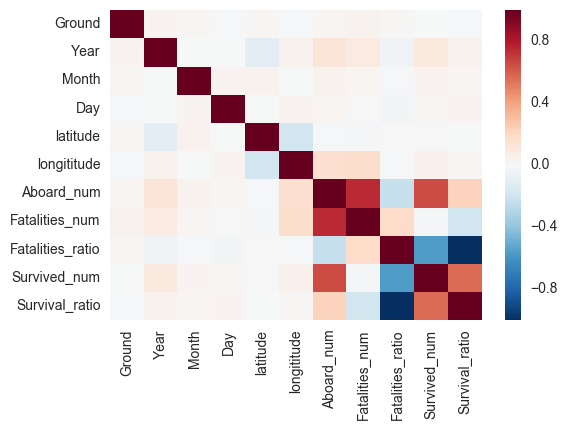

In [28]:
sns.heatmap(df_all.corr())

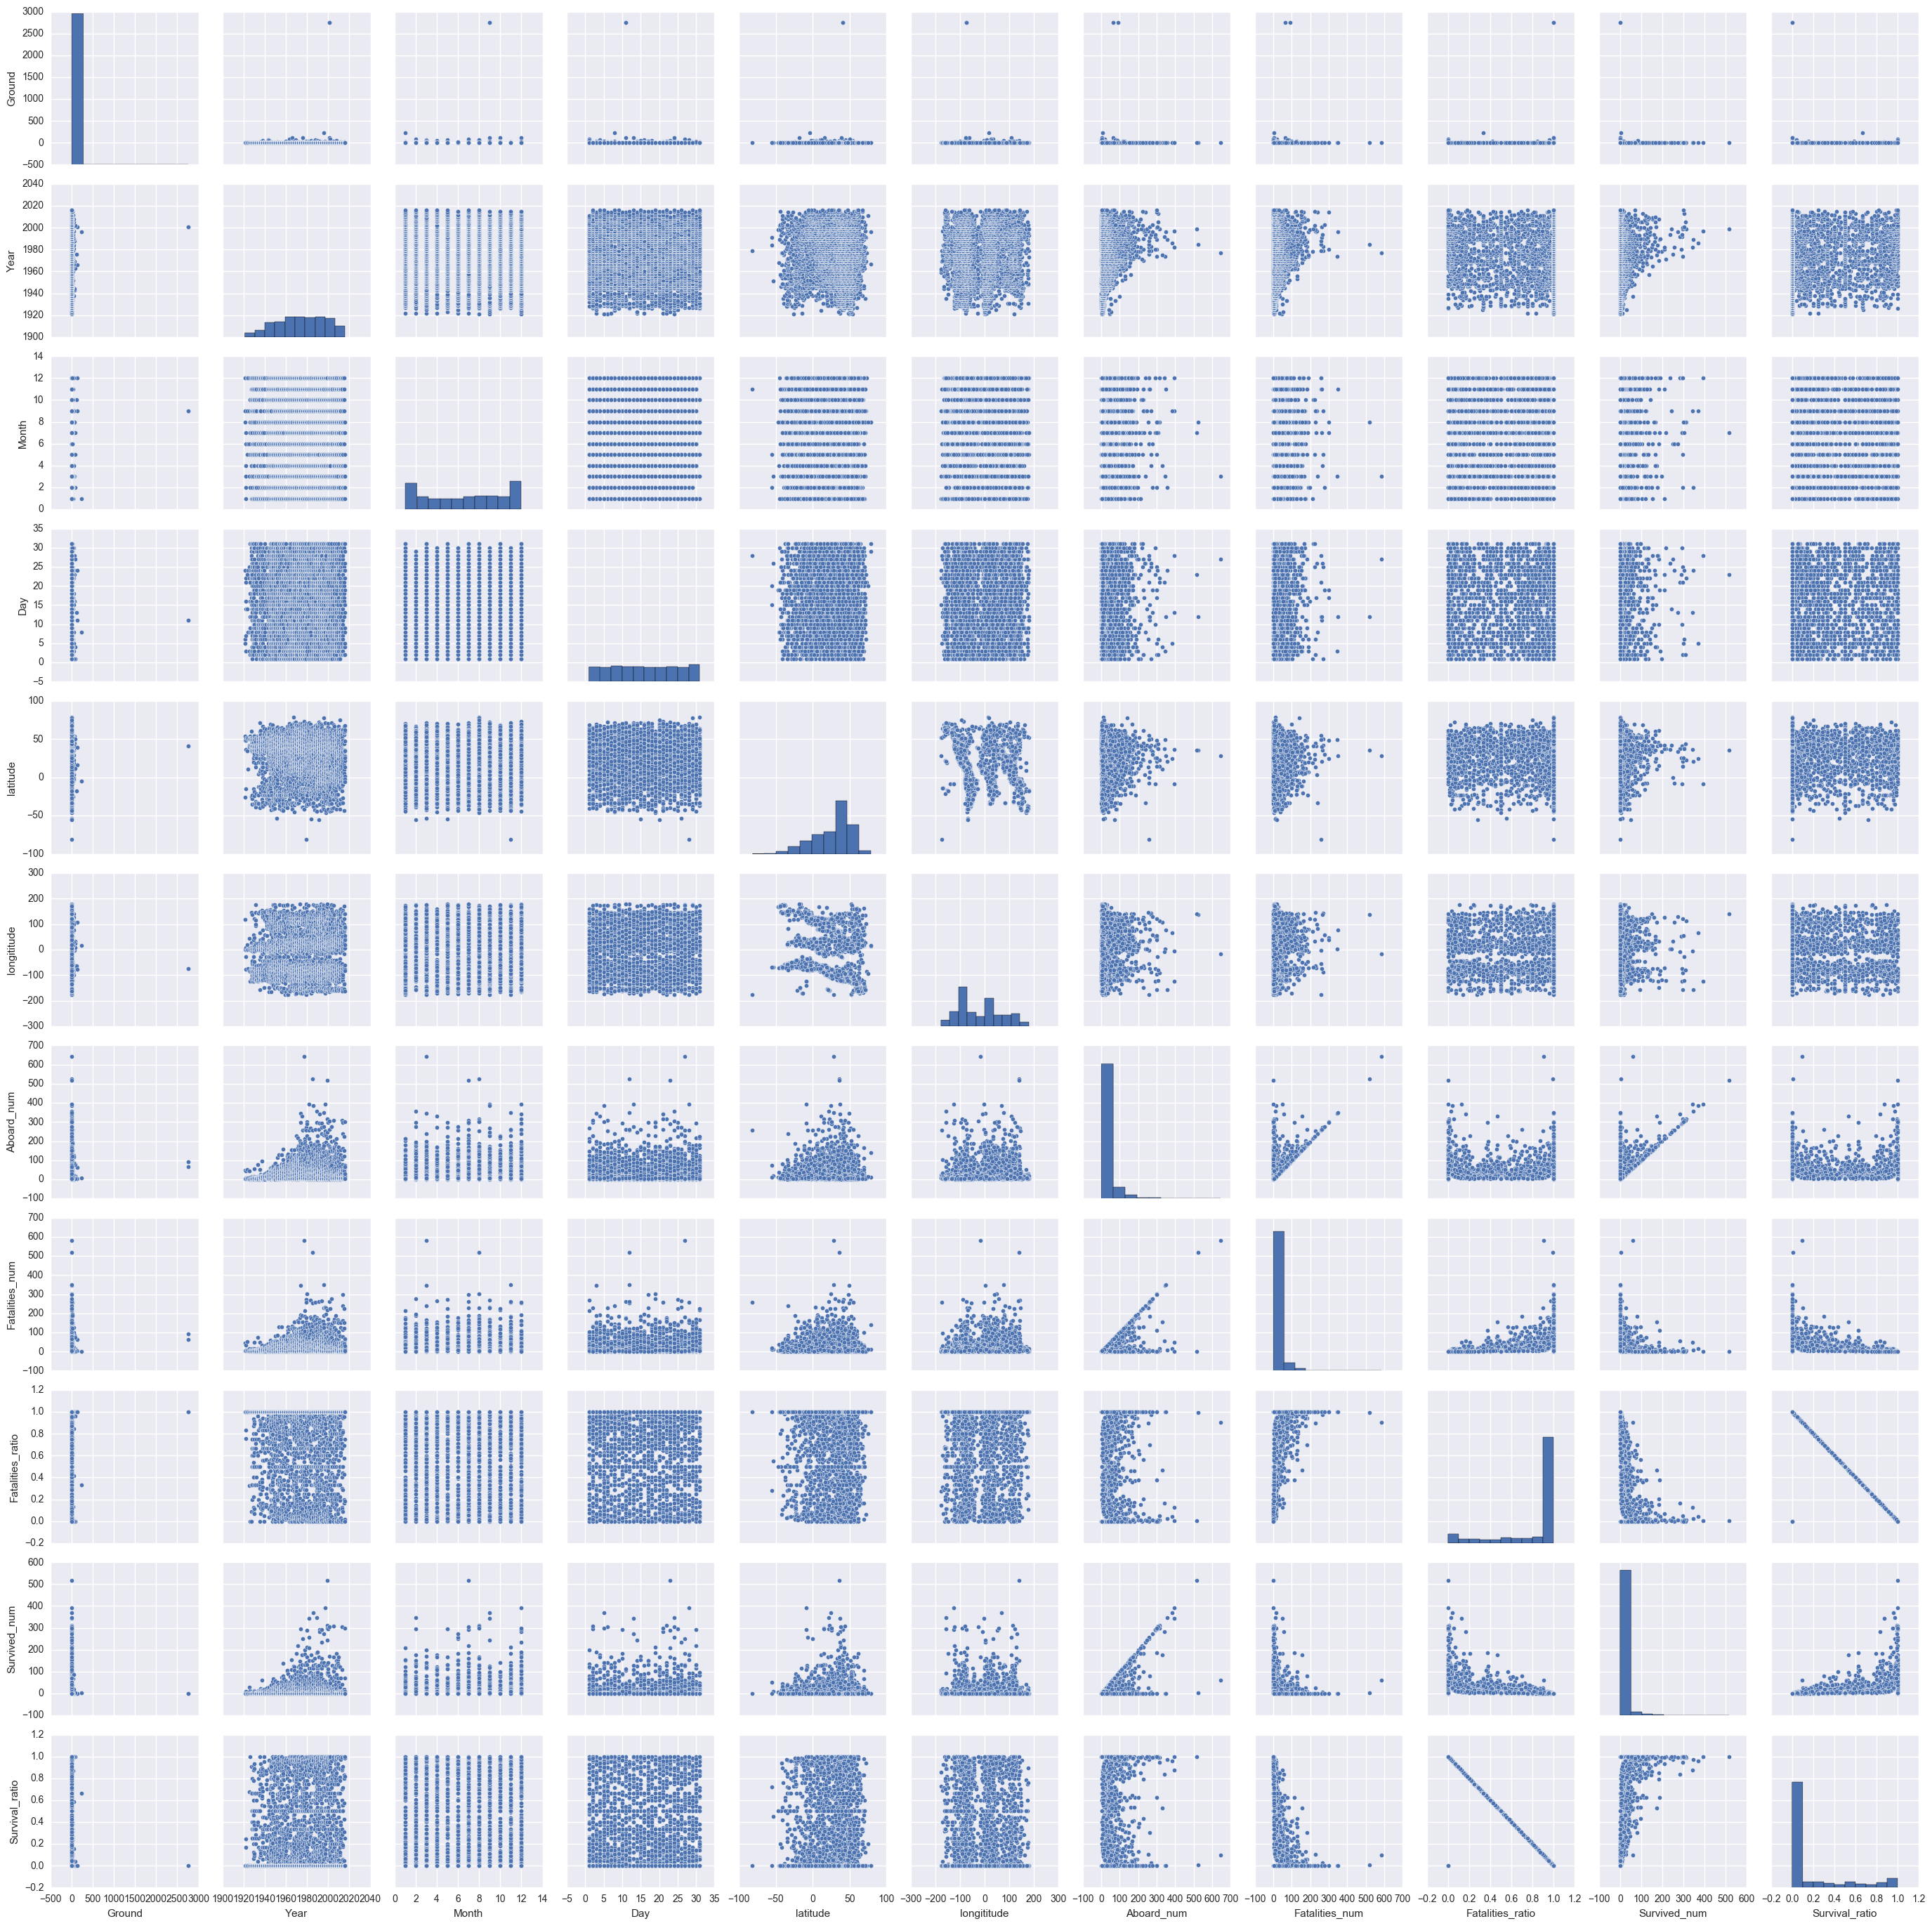

In [9]:
sns.pairplot(df_all)

In [29]:
df_all.describe()

Ground         Year        Month          Day     latitude  \
count  4941.000000  4941.000000  4941.000000  4941.000000  4941.000000   
mean      1.735276  1974.317749     6.624975    15.758753    27.238312   
std      55.633604    22.576165     3.553754     8.804540    24.741813   
min       0.000000  1921.000000     1.000000     1.000000   -81.499969   
25%       0.000000  1957.000000     3.000000     8.000000    11.410925   
50%       0.000000  1975.000000     7.000000    16.000000    34.540024   
75%       0.000000  1993.000000    10.000000    23.000000    44.103691   
max    2750.000000  2016.000000    12.000000    31.000000    78.901360   

       longititude   Aboard_num  Fatalities_num  Fatalities_ratio  \
count  4941.000000  4941.000000     4941.000000       4941.000000   
mean    -17.569013    28.231532       20.209877          0.825664   
std      83.959274    43.770406       33.223801          0.305824   
min    -177.376111     0.000000        0.000000          0.000000   
25%     -84.090725     5.000000        3.000000          0.766667   
50%     -21.425040    13.000000        9.000000          1.000000   
75%      37.617300    31.000000       23.000000          1.000000   
max     178.749400   644.000000      583.000000          1.000000   

       Survived_num  Survival_ratio  
count   4941.000000     4941.000000  
mean       8.021656        0.173527  
std       29.214337        0.304960  
min        0.000000        0.000000  
25%        0.000000        0.000000  
50%        0.000000        0.000000  
75%        3.000000        0.230769  
max      516.000000        1.000000

## Exploring the regression for Fatalities ratio, Survival ratio, Ground with Year data

- EDA for regression for fatalities ration, survival ration and Ground data with year as x values and see if there are any regresssion appreaing
- Ignoring all the fatalities where it is 0 and making that we can much better result

In [11]:
len(df_all[df_all['Fatalities_num']>0])

4877

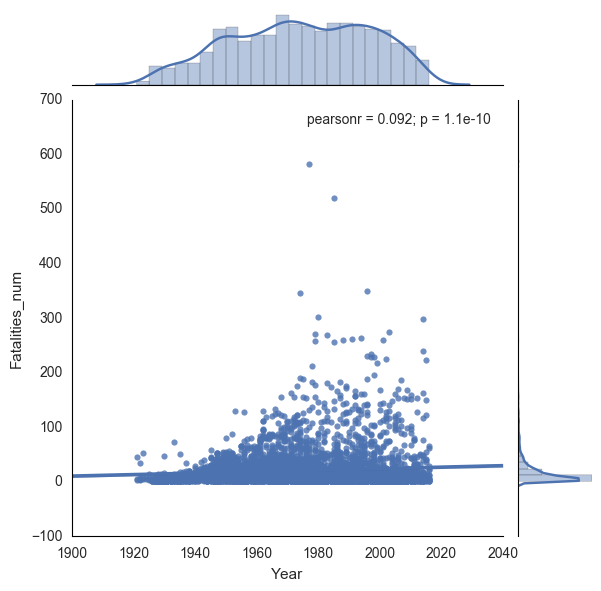

In [12]:
g = sns.jointplot(x="Year", y="Fatalities_num", data=df_all[df_all['Fatalities_num']<>0], kind="reg")

From the above we can see that year data is normally distributed but where as the Fatalities number has not been normally distributed. It might be skewed more towards right. Lets check the denisty of data where it more occurs, the most fatalities number occur between 0 to 100. Others are outliers

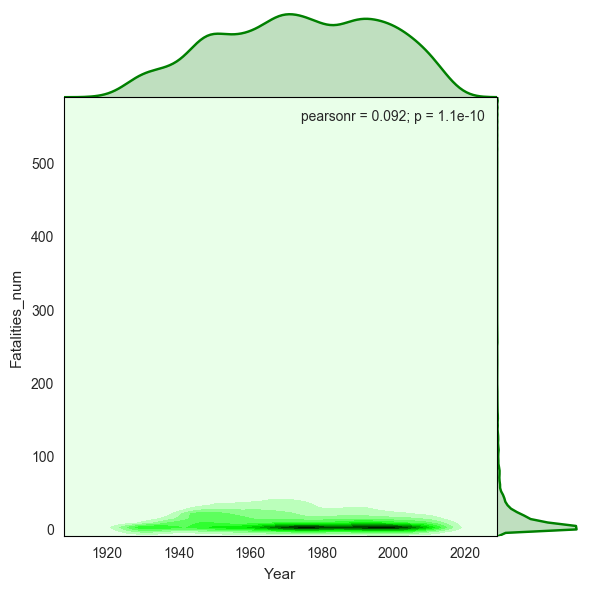

In [13]:
#finding the density of where the most occuring data
g = sns.jointplot("Year", "Fatalities_num", data=df_all[df_all['Fatalities_num']<>0],
                  kind="kde", space=0, color="g")

Similarly if we take closer look at the Survival number as well the more data is occuring between 0 to nearly 100

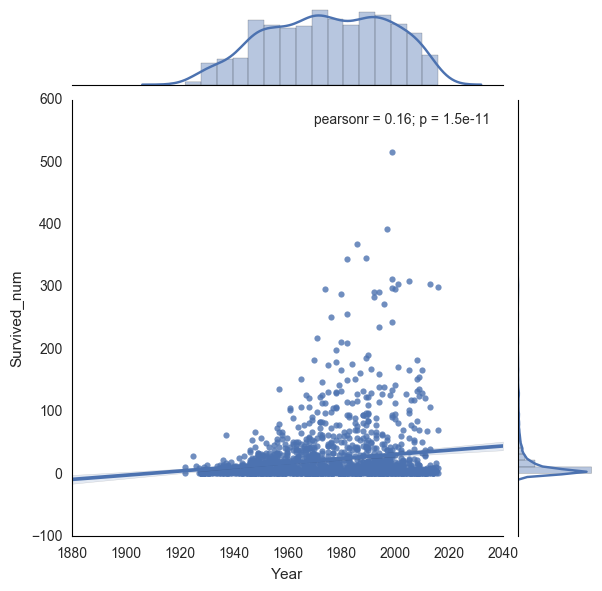

In [14]:
g = sns.jointplot(x="Year", y="Survived_num", data=df_all[df_all['Survived_num']<>0], kind="reg")

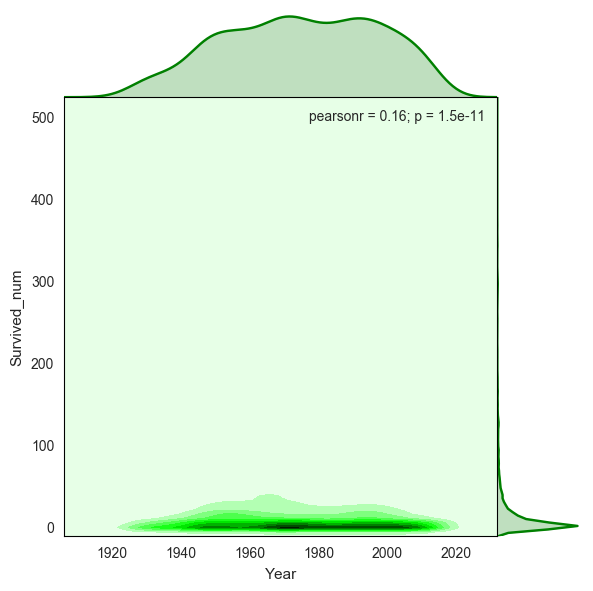

In [15]:
#finding the density of where the most occuring data
g = sns.jointplot("Year", "Survived_num", data=df_all[df_all['Survived_num']<>0],
                  kind="kde", space=0, color="g")

# Fatalities Ratio - Regresor Modeling
## Convert categorical values into numbers as dummies

In [30]:
#country, manufacturer ac type, reasons for crash are categorical data and get them dummies below

In [147]:
df_country_dummy = pd.get_dummies(df_all['loccountry'],drop_first=True)
df_actype_dummy = pd.get_dummies(df_all['Manufacturer_ac_type'], drop_first=True)
df_reasoncrash_dummy = pd.get_dummies(df_all['reason_crash'], drop_first=True)

In [148]:
#merged above all dummies dataframe into one dataframe

In [149]:
df_all_dummies = pd.concat([df_country_dummy,df_actype_dummy,df_reasoncrash_dummy], axis=1)

In [150]:
df_all_dummies.shape # Total dummies itself has 300 features

(4941, 300)

In [151]:
#creating features columns to use for X
features = ['Ground', 'Year', 'Month', 'Day', 'latitude', 'longititude','Aboard_num','Survived_num',
            'Fatalities_num','Fatalities_ratio','Survival_ratio']

In [152]:
#final dataframe with dummies 
df_final = pd.concat([df_all[features],df_all_dummies],axis=1)
print df_final.shape

(4941, 311)


In [153]:
#Creating dataframe where non-zero fatalities number which will make more sense to the model
df_fatalities = df_final[df_final['Fatalities_num']<>0]
print "Fatalities non-zero dataframe shpae:",df_fatalities.shape

Fatalities non-zero dataframe shpae: (4877, 311)


In [154]:
#Creating dataframe where non-zero Survival number which will make more sense to the model
df_survivals = df_final[df_final['Survived_num']<>0]
print "This means considering only the crashes where some of the are survived. \nIgnoring those where all of them died"
print "Survival non-zero dataframe shpae:",df_survivals.shape

This means considering only the crashes where some of the are survived. 
Ignoring those where all of them died
Survival non-zero dataframe shpae: (1714, 311)


## Handling some zero fatalities before modeling or Outliers
- There are 64 crashes where the airplanes are crashed but no one died.
- If we look at the reasons for the crash for these 64 rows they are may be due to weather conditions, take off landing and some cargo planes where pilot would have escaped from the crash using parachute
- Using above ignoring the fatalities where it is 0, there are some occurrence where airplace crash occured and no one has died, which may not be relevant to the model to predict the fatalities ratio where it is 0.

In [155]:
print "Total number of crashes where no one died:", len(df_all[df_all['Fatalities_num']==0])
print "Reasons for crash where no one died:"
df_all[df_all['Fatalities_num']==0]['reason_crash'].value_counts()

Total number of crashes where no one died: 64
Reasons for crash where no one died:


landing-takeoff       27
pilot error           11
shot down             10
weather conditions     8
None                   4
engine error           2
fuel exhaustion        1
others-cargo           1
Name: reason_crash, dtype: int64

## Handling some zero survivals before modeling or Outliers
- There are 3277 crashes where the airplanes are crashed and all of them died.
- To be able to predict the survival ratio we might focus more on when accident happen and there are some people survived. In this case there are 1714 crashes where some people have survived. It is best to focus on if crash occurs and not all of them died then what is the ratio of survival.

In [156]:
print "Total number of crashes where no one survived:", len(df_all[df_all['Survived_num']==0])
print "Total number of crashes where people survived:", len(df_all[df_all['Survived_num']<>0])
print "Reasons for crash where no one survived:"
df_all[df_all['Survived_num']==0]['reason_crash'].value_counts()

Total number of crashes where no one survived: 3227
Total number of crashes where people survived: 1714
Reasons for crash where no one survived:


landing-takeoff       1046
weather conditions     873
None                   383
pilot error            276
shot down              219
engine error           211
stall                   71
due to fire             57
others-cargo            45
fuel exhaustion         24
others-missing          12
terrorism               10
Name: reason_crash, dtype: int64

## Creating features(X) and target(y) variables for model 

In [157]:
new_features = ['Ground', 'Year', 'Month', 'Day', 'latitude', 'longititude','Aboard_num','Survived_num',
                'Fatalities_num']
y_feature = ['Fatalities_ratio','Survival_ratio']

In [158]:
#X for Fatalities 
Xf = df_fatalities
Xf = Xf.drop(['Fatalities_num','Survived_num','Fatalities_ratio','Survival_ratio'], axis=1)

In [159]:
Xs = df_survivals
Xs = Xs.drop(['Survived_num','Fatalities_num','Fatalities_ratio','Survival_ratio'], axis=1)

In [160]:
print "Fatalities X -------"
print "Total number of features in X :", Xf.shape[1]
print "Total number of rows in X :    ", Xf.shape[0]
print "Survivals X -------"
print "Total number of features in X :", Xs.shape[1]
print "Total number of rows in X :    ", Xs.shape[0]

Fatalities X -------
Total number of features in X : 307
Total number of rows in X :     4877
Survivals X -------
Total number of features in X : 307
Total number of rows in X :     1714


Creating two target variables here for prediction model. First would like to predict Fatalities ratio and then also would like to predict Survival ratio based on the available data
- First y is Fatalities ratio
- Second ys is Survival ratio



In [161]:
yf = df_fatalities['Fatalities_ratio']
ys = df_survivals['Survival_ratio']

## Linear Regression model for Fatalities Ratio

As the target varibales are numeric value and best to start with linear regression model from sklearn which will show the basic understanding of our data with the model. The necessary packages have been imported.

We have already converted the necessary variables into dummies and asssigned X and y values for the model.

Then we are dividing the train and test test for our model with 80:20% split here.

In [26]:
# divinging the data into train and test set to avoid overfitting. 80:20 (Train and Test set) 
Xf_train, Xf_test, yf_train, yf_test = train_test_split(Xf,yf,test_size=0.20,random_state=42)

In [27]:
#creating and fitting model
model_reg = LinearRegression()
model_reg_fit = model_reg.fit(Xf_train,yf_train)
predictions_reg = model_reg_fit.predict(Xf_test)

In [28]:
model_reg_mse = mean_squared_error(yf_test,predictions_reg)
model_reg_mae = mean_absolute_error(yf_test,predictions_reg)
model_reg_rmse= math.sqrt(mean_squared_error(yf_test, predictions_reg))
model_reg_r2 = r2_score(yf_test,predictions_reg)
print "Linear Regression model metrics:"
print "--------------------------------"
print 'Mean Squared Error: \t',mean_squared_error(yf_test,predictions_reg)
print 'Mean Absolute Error: \t',mean_absolute_error(yf_test,predictions_reg)
print 'Root MSE:\t\t', math.sqrt(mean_squared_error(yf_test, predictions_reg))

print 'r^2 Score: \t\t', r2_score(yf_test,predictions_reg)

Linear Regression model metrics:
--------------------------------
Mean Squared Error: 	3.52749718424e+17
Mean Absolute Error: 	27018614.601
Root MSE:		593927367.97
r^2 Score: 		-3.81277629228e+18


First glannce of linear regression model has provided some score to start with, which is -negative r^2 score.  Lets visualise the predictions and see how it looks at first

				Predicting Fatalities Ratio per accident


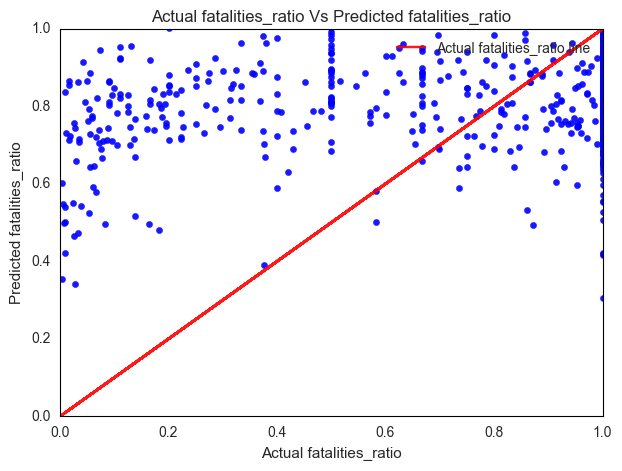

In [29]:
print "\t\t\t\tPredicting Fatalities Ratio per accident"
fig = plt.figure(figsize=(7,5))
ax1 = fig.add_subplot(111)
ax1.scatter(yf_test, predictions_reg, color='blue', alpha=.9)
ax1.set(xlabel='Actual fatalities_ratio',ylabel='Predicted fatalities_ratio',
        title='Actual fatalities_ratio Vs Predicted fatalities_ratio',
       xlim=[0,1],
       ylim=[0,1])
ax1.plot(yf_test,yf_test,color='red',alpha=.9,label='Actual fatalities_ratio line')
plt.legend()
plt.show()

After reducing some noise initially be ignoring the those where there are no fatalities and progressed with those where there are some fatatlies in the acccident, produced some good linear fit. 

There are 308 features used to predict fatalities ratio, among which are 3 categorical features location of the crash, aircraft types, and reasons for crash. So getting dummies for these 3 values resulted in 300 features.

LinearRegression model has provided -ive r2 score which is -3.81277629228e+18, eventhough its not good but its something to start as baseline and improve the model with some hyper parameters, so lets try Lasso and ridge model to futher improve the model performance.

## Lasso Model for Fatalities ratio

Lasso Regression model metrics:
--------------------------------
Mean Squared Error: 	0.0877898755362
Mean Absolute Error: 	0.229789970558
Root MSE:		0.296293563103
r^2 Score: 		0.0511029813367


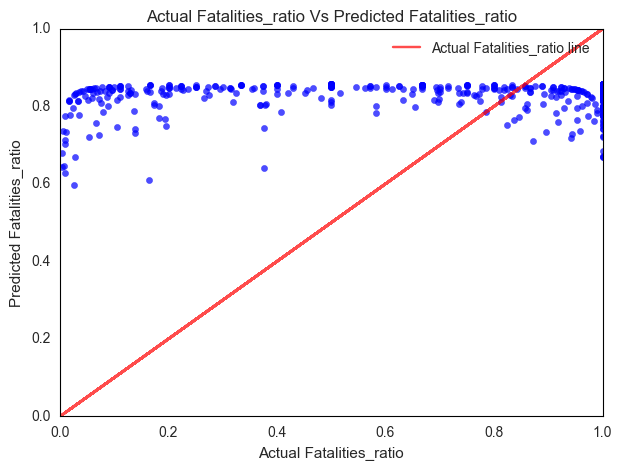

In [30]:
model_Lasso = Lasso()
model_Lasso_fit = model_Lasso.fit(Xf_train,yf_train)
predictions_lasso = model_Lasso_fit.predict(Xf_test)
model_lasso_mse = mean_squared_error(yf_test,predictions_lasso)
model_lasso_mae = mean_absolute_error(yf_test,predictions_lasso)
model_lasso_rmse= math.sqrt(mean_squared_error(yf_test, predictions_lasso))
model_lasso_r2 = r2_score(yf_test,predictions_lasso)
print "Lasso Regression model metrics:"
print "--------------------------------"
print 'Mean Squared Error: \t',mean_squared_error(yf_test,predictions_lasso)
print 'Mean Absolute Error: \t',mean_absolute_error(yf_test,predictions_lasso)
print 'Root MSE:\t\t', math.sqrt(mean_squared_error(yf_test, predictions_lasso))

print 'r^2 Score: \t\t', r2_score(yf_test,predictions_lasso)
fig = plt.figure(figsize=(7,5))
ax1 = fig.add_subplot(111)
ax1.scatter(yf_test, predictions_lasso, color='blue', alpha=.7)
ax1.set(xlabel='Actual Fatalities_ratio',
        ylabel='Predicted Fatalities_ratio',
        title='Actual Fatalities_ratio Vs Predicted Fatalities_ratio',
        xlim=[0,1],
        ylim=[0,1])
ax1.plot(yf_test,yf_test,color='red',alpha=.7,label='Actual Fatalities_ratio line')
plt.legend()
plt.show()

## LassoCV Model for Fatalities ratio (Regularisation)

LassoCV Regression model metrics:
--------------------------------
Mean Squared Error: 	0.0810492267649
Mean Absolute Error: 	0.215458048426
Root MSE:		0.28469145889
r^2 Score: 		0.123960830648


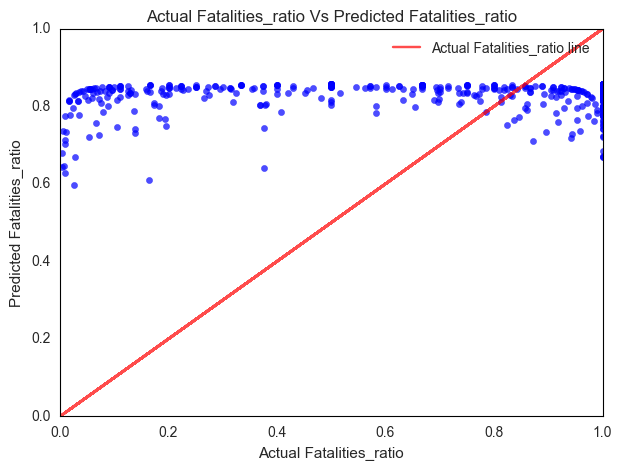

In [31]:
model_Lassocv = LassoCV(cv=5,n_alphas=300, normalize=False)
model_Lassocv_fit = model_Lassocv.fit(Xf_train,yf_train)
predictions_lassocv = model_Lassocv_fit.predict(Xf_test)
model_lassocv_mse = mean_squared_error(yf_test,predictions_lassocv)
model_lassocv_mae = mean_absolute_error(yf_test,predictions_lassocv)
model_lassocv_rmse= math.sqrt(mean_squared_error(yf_test, predictions_lassocv))
model_lassocv_r2 = r2_score(yf_test,predictions_lassocv)
print "LassoCV Regression model metrics:"
print "--------------------------------"
print 'Mean Squared Error: \t',mean_squared_error(yf_test,predictions_lassocv)
print 'Mean Absolute Error: \t',mean_absolute_error(yf_test,predictions_lassocv)
print 'Root MSE:\t\t', math.sqrt(mean_squared_error(yf_test, predictions_lassocv))

print 'r^2 Score: \t\t', r2_score(yf_test,predictions_lassocv)
fig = plt.figure(figsize=(7,5))
ax1 = fig.add_subplot(111)
ax1.scatter(yf_test, predictions_lasso, color='blue', alpha=.7)
ax1.set(xlabel='Actual Fatalities_ratio',
        ylabel='Predicted Fatalities_ratio',
        title='Actual Fatalities_ratio Vs Predicted Fatalities_ratio',
        xlim=[0,1],
        ylim=[0,1])
ax1.plot(yf_test,yf_test,color='red',alpha=.7,label='Actual Fatalities_ratio line')
plt.legend()
plt.show()

From the above it seems the LassoCV has improved to 0.12 r^2 score compared to Lasso model above even with simple regularisation techniques. 

## Ridge Model for Fatalities ratio

Ridge Regression model metrics:
--------------------------------
Mean Squared Error: 	0.0838843880744
Mean Absolute Error: 	0.217731258116
Root MSE:		0.289628016729
r^2 Score: 		0.0933163389281


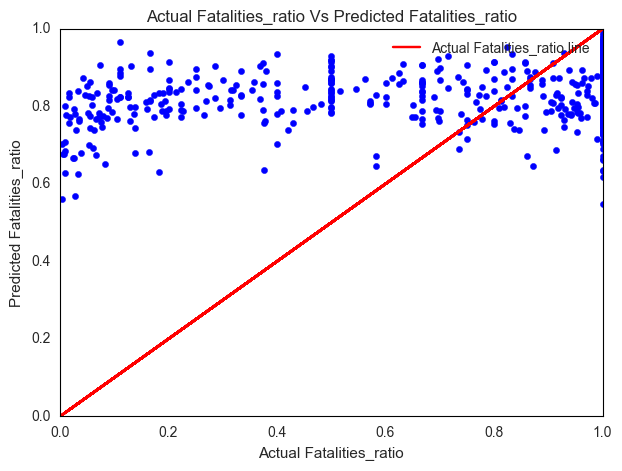

In [32]:
model_rd = Ridge(normalize=True)
model_rd_fit = model_rd.fit(Xf_train,yf_train)
predictions_ridge = model_rd_fit.predict(Xf_test)
model_ridge_mse = mean_squared_error(yf_test,predictions_ridge)
model_ridge_mae = mean_absolute_error(yf_test,predictions_ridge)
model_ridge_rmse= math.sqrt(mean_squared_error(yf_test, predictions_ridge))
model_ridge_r2 = r2_score(yf_test,predictions_ridge)
print "Ridge Regression model metrics:"
print "--------------------------------"
print 'Mean Squared Error: \t',mean_squared_error(yf_test,predictions_ridge)
print 'Mean Absolute Error: \t',mean_absolute_error(yf_test,predictions_ridge)
print 'Root MSE:\t\t', math.sqrt(mean_squared_error(yf_test, predictions_ridge))

print 'r^2 Score: \t\t', r2_score(yf_test,predictions_ridge)
fig = plt.figure(figsize=(7,5))
ax1 = fig.add_subplot(111)
ax1.scatter(yf_test, predictions_ridge, color='blue')
ax1.set(xlabel='Actual Fatalities_ratio',
        ylabel='Predicted Fatalities_ratio',
        title='Actual Fatalities_ratio Vs Predicted Fatalities_ratio',
        xlim=[0,1],
        ylim=[0,1])
ax1.plot(yf_test,yf_test,color='red',label='Actual Fatalities_ratio line')
plt.legend()
plt.show()

Lasso and Ridge model has already uses some regularisation techniques. Simply appliying Lasso and Ridge model has improved the r^2 score significantly from normal linearRegression model. 

Lassocv model has provided 0.12 score compared to ridge model which has 0.09. These are not best score but something to start for our model. Mean squared Error also improved in Ridge model by 0.01. From this Ridge model proves with good results. So lets try with Ridge CV model

## RidgeCV Model for Fatalities ratio

RidgeCV Regression model metrics:
--------------------------------
Mean Squared Error: 	0.0838843880744
Mean Absolute Error: 	0.217731258116
Root MSE:		0.289628016729
r^2 Score: 		0.0992067518099
Best Alpha: 0.7


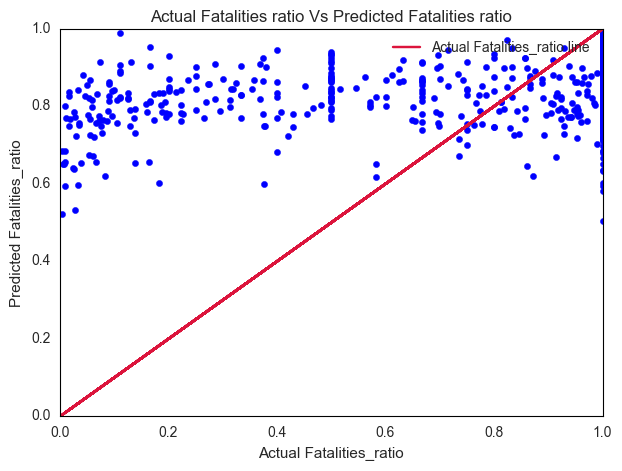

In [33]:
model_rdcv = RidgeCV(alphas=np.arange(-2.5, 2.5, 0.1),normalize=True)
model_rdcv_fit = model_rdcv.fit(Xf_train,yf_train)
predictions_ridgecv = model_rdcv_fit.predict(Xf_test)
model_ridgecv_mse = mean_squared_error(yf_test,predictions_ridgecv)
model_ridgecv_mae = mean_absolute_error(yf_test,predictions_ridgecv)
model_ridgecv_rmse= math.sqrt(mean_squared_error(yf_test, predictions_ridgecv))
model_ridgecv_r2 = r2_score(yf_test,predictions_ridgecv)
print "RidgeCV Regression model metrics:"
print "--------------------------------"
print 'Mean Squared Error: \t',mean_squared_error(yf_test,predictions_ridge)
print 'Mean Absolute Error: \t',mean_absolute_error(yf_test,predictions_ridge)
print 'Root MSE:\t\t', math.sqrt(mean_squared_error(yf_test, predictions_ridge))

print 'r^2 Score: \t\t', r2_score(yf_test,predictions_ridgecv)
print "Best Alpha:", model_rdcv.alpha_
fig = plt.figure(figsize=(7,5))
ax1 = fig.add_subplot(111)
ax1.scatter(yf_test, predictions_ridgecv, color='blue')
ax1.set(xlabel='Actual Fatalities_ratio',
        ylabel='Predicted Fatalities_ratio',
        title='Actual Fatalities ratio Vs Predicted Fatalities ratio',
        xlim=[0,1],
        ylim=[0,1])
ax1.plot(yf_test,yf_test,color='crimson',label='Actual Fatalities_ratio line')
plt.legend()
plt.show()

RidgeCV model with multiple try of different values for alphas, the best is 0.1 and the r^2 score hasn't improved compared to the normal ridge model which means the regularisation techniques are not improving here.

From the above LassoCV is the best model which has provided 0.12% score

## Grid Search for Lasso and Ridge for  Fatalities ratio

In [34]:
params = {'alpha':np.logspace(-2.5,4.5,10)}
lasso = Lasso(max_iter=3000, fit_intercept=True)
gs = GridSearchCV(lasso,params,cv=10)
model = gs.fit(Xf_train,yf_train)
print 'Best alpha: ',model.best_params_
print 'Best score: ',model.best_score_
print 'Best estimator:', model.best_estimator_
model.grid_scores_

Best alpha:  {'alpha': 0.0031622776601683794}
Best score:  0.0557879230869
Best estimator: Lasso(alpha=0.0031622776601683794, copy_X=True, fit_intercept=True,
   max_iter=3000, normalize=False, positive=False, precompute=False,
   random_state=None, selection='cyclic', tol=0.0001, warm_start=False)


[mean: 0.05579, std: 0.03323, params: {'alpha': 0.0031622776601683794},
 mean: 0.03387, std: 0.03395, params: {'alpha': 0.018957356524063752},
 mean: 0.02853, std: 0.03136, params: {'alpha': 0.11364636663857249},
 mean: 0.02650, std: 0.02274, params: {'alpha': 0.68129206905796147},
 mean: -0.00346, std: 0.00449, params: {'alpha': 4.0842386526745216},
 mean: -0.00346, std: 0.00449, params: {'alpha': 24.484367468222267},
 mean: -0.00346, std: 0.00449, params: {'alpha': 146.77992676220705},
 mean: -0.00346, std: 0.00449, params: {'alpha': 879.92254356910746},
 mean: -0.00346, std: 0.00449, params: {'alpha': 5274.9970637026199},
 mean: -0.00346, std: 0.00449, params: {'alpha': 31622.776601683792}]

Lasso GridSearch Regression model metrics:
--------------------------------
Mean Squared Error: 	0.0814121846937
Mean Absolute Error: 	0.21682580646
Root MSE:		0.285328205219
r^2 Score: 		0.120037716572


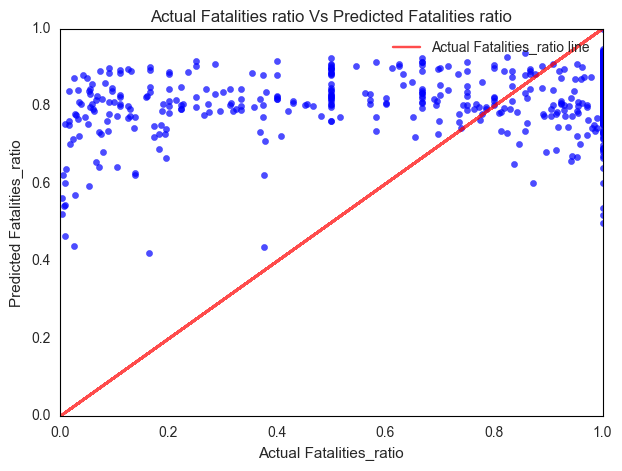

In [35]:
lasso_gs_model = model.best_estimator_.fit(Xf_train,yf_train)
lasso_gs_pred = lasso_gs_model.predict(Xf_test)

model_lasso_gs_mse = mean_squared_error(yf_test,lasso_gs_pred)
model_lasso_gs_mae = mean_absolute_error(yf_test,lasso_gs_pred)
model_lasso_gs_rmse= math.sqrt(mean_squared_error(yf_test, lasso_gs_pred))
model_lasso_gs_r2 = r2_score(yf_test,lasso_gs_pred)

print "Lasso GridSearch Regression model metrics:"
print "--------------------------------"
print 'Mean Squared Error: \t',mean_squared_error(yf_test,lasso_gs_pred)
print 'Mean Absolute Error: \t',mean_absolute_error(yf_test,lasso_gs_pred)
print 'Root MSE:\t\t', math.sqrt(mean_squared_error(yf_test, lasso_gs_pred))

print 'r^2 Score: \t\t', r2_score(yf_test,lasso_gs_pred)
fig = plt.figure(figsize=(7,5))
ax1 = fig.add_subplot(111)
ax1.scatter(yf_test, lasso_gs_pred, color='blue', alpha=.7)
ax1.set(xlabel='Actual Fatalities_ratio',
        ylabel='Predicted Fatalities_ratio',
        title='Actual Fatalities ratio Vs Predicted Fatalities ratio',
        xlim=[0,1],
        ylim=[0,1])
ax1.plot(yf_test,yf_test,color='red',alpha=.7,label='Actual Fatalities_ratio line')
plt.legend()
plt.show()

In [36]:
#grid search for ridge model
params = {'alpha':np.logspace(-5,5,10)}
rid = Ridge(max_iter=3000)
gs = GridSearchCV(rid,params,cv=10)
model = gs.fit(Xf_train,yf_train)
print 'alpha: ',model.best_params_
print 'Best score: ',model.best_score_
model.grid_scores_

alpha:  {'alpha': 46.415888336127821}
Best score:  0.0737018042708


[mean: -0.01108, std: 0.07685, params: {'alpha': 1.0000000000000001e-05},
 mean: -0.01104, std: 0.07684, params: {'alpha': 0.00012915496650148841},
 mean: -0.01063, std: 0.07678, params: {'alpha': 0.0016681005372000592},
 mean: -0.00741, std: 0.07641, params: {'alpha': 0.021544346900318846},
 mean: 0.00979, std: 0.07183, params: {'alpha': 0.27825594022071259},
 mean: 0.05212, std: 0.05871, params: {'alpha': 3.5938136638046259},
 mean: 0.07370, std: 0.04057, params: {'alpha': 46.415888336127821},
 mean: 0.05829, std: 0.03448, params: {'alpha': 599.48425031894214},
 mean: 0.03365, std: 0.03463, params: {'alpha': 7742.6368268112774},
 mean: 0.02883, std: 0.03405, params: {'alpha': 100000.0}]

Ridge GridSearch Regression model metrics:
--------------------------------
Mean Squared Error: 	0.0802020059073
Mean Absolute Error: 	0.210059795109
Root MSE:		0.2831995867
r^2 Score: 		0.133118211736


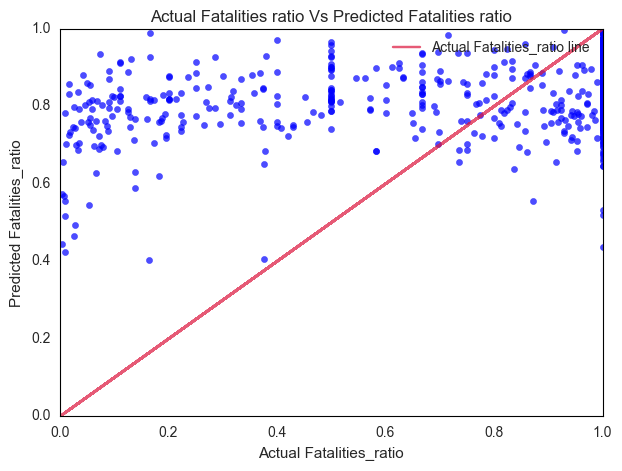

In [37]:
ridge_gs_model = model.best_estimator_.fit(Xf_train,yf_train)
ridge_gs_pred = ridge_gs_model.predict(Xf_test)

model_ridge_gs_mse = mean_squared_error(yf_test,ridge_gs_pred)
model_ridge_gs_mae = mean_absolute_error(yf_test,ridge_gs_pred)
model_ridge_gs_rmse= math.sqrt(mean_squared_error(yf_test, ridge_gs_pred))
model_ridge_gs_r2 = r2_score(yf_test,ridge_gs_pred)

print "Ridge GridSearch Regression model metrics:"
print "--------------------------------"
print 'Mean Squared Error: \t',mean_squared_error(yf_test,ridge_gs_pred)
print 'Mean Absolute Error: \t',mean_absolute_error(yf_test,ridge_gs_pred)
print 'Root MSE:\t\t', math.sqrt(mean_squared_error(yf_test, ridge_gs_pred))

print 'r^2 Score: \t\t', r2_score(yf_test,ridge_gs_pred)
fig = plt.figure(figsize=(7,5))
ax1 = fig.add_subplot(111)
ax1.scatter(yf_test, ridge_gs_pred, color='blue', alpha=.7)
ax1.set(xlabel='Actual Fatalities_ratio',
        ylabel='Predicted Fatalities_ratio',
        title='Actual Fatalities ratio Vs Predicted Fatalities ratio',
        xlim=[0,1],
        ylim=[0,1])
ax1.plot(yf_test,yf_test,color='crimson',alpha=.7,label='Actual Fatalities_ratio line')
plt.legend()
plt.show()

After exploring the gird search with mulptile alpha values the score hasn't improved very much. But it has increase 1% in r^2 score. But its always recommended to see whether gird search has provides any best results or not. In this case it has for ridge provided any notified results.

After trying with Linear Regression models for predicting fatalaties ratio and it wasn't progression much with the score till 0.13%, now its better try with Decision tree models like DecisionTreeRegressor, RandomForest and some regressor techniques

## Decision Tree Regressor

In [38]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import BaggingRegressor

In [39]:
#Creating decisiontree regressor
tree = DecisionTreeRegressor(random_state=1,max_depth=8)
tree.fit(Xf_train, yf_train)

DecisionTreeRegressor(criterion='mse', max_depth=8, max_features=None,
           max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=1,
           splitter='best')

In [40]:
# make predictions
preds = tree.predict(Xf_test)

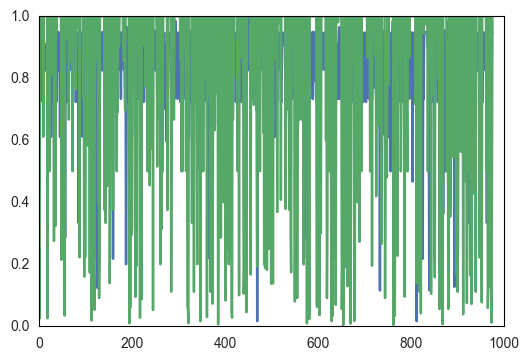

In [41]:
# print predictions and actual values
plt.plot(preds)
plt.plot(yf_test.values)

In [42]:
tree_score = r2_score(yf_test, preds)
print "r^2 score of Decision Tree",tree_score

r^2 score of Decision Tree 0.0163776639664


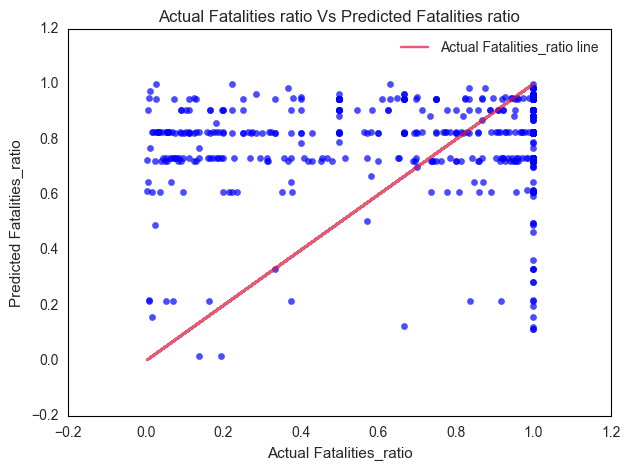

In [43]:
fig = plt.figure(figsize=(7,5))
ax1 = fig.add_subplot(111)
ax1.scatter(yf_test, preds, color='blue', alpha=.7)
ax1.set(xlabel='Actual Fatalities_ratio',
        ylabel='Predicted Fatalities_ratio',
        title='Actual Fatalities ratio Vs Predicted Fatalities ratio')
        #xlim=[0,1],
        #ylim=[0,1])
ax1.plot(yf_test,yf_test,color='crimson',alpha=.7,label='Actual Fatalities_ratio line')
plt.legend()
plt.show()


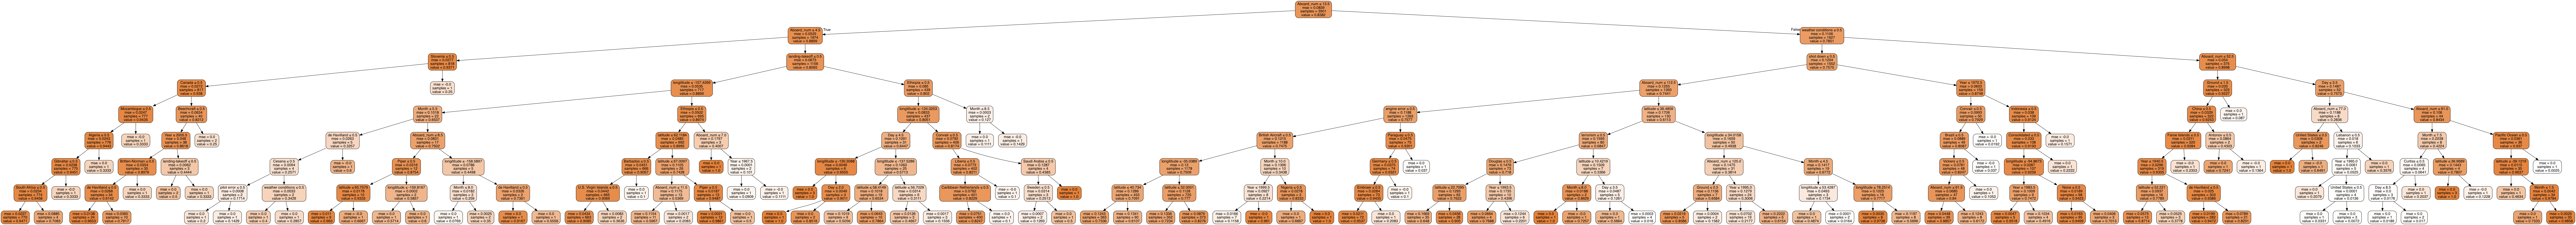

In [44]:
from IPython.display import Image
from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO
import pydot

dot_data = StringIO()  
export_graphviz(tree, out_file=dot_data,  
                feature_names=Xf.columns,  
                filled=True, rounded=True,  
                special_characters=True)  
graph = pydot.graph_from_dot_data(dot_data.getvalue())  
Image(graph[0].create_png()) 

Finally realised the decision tree models are predicting very well with predicting fatalities ratio, then would like to try with not avoiding any of the accidents where there are no fatalities, those 64 rows. So I decided to introdue those and try with decision tree regressor and try how it works

After experimenting with the model and figured that 'Survival_num' (number of people survied per crash) has been feed into the decision tree model to predict the 'Fatalities_ratio' (rate of people died per crash) which is completely opposite. But after rectifying and removing the Survival num has resulted in -73.3% accurarcy and there are not clear fitting in this model. 

Next steps would be creating another derived feature 'Fatality_classification' (low, medium, high fatalaty) per accident might be helpful in predicting in much better, rather than accurate number of fatalities or ratio.

Also there are not enough features like fight journery duration, time of the flight, flight maintanence and weather report of accident place or any detailed malfunction features were not available to predict the fatalities accurately. Those would play much vital role in that.

## Randaom Forest

In [45]:
from sklearn.ensemble import RandomForestRegressor


rfr = RandomForestRegressor(random_state=1)
rfr.fit(Xf_train, yf_train)

pred_rf = rfr.predict(Xf_test)
rfc_score = rfr.score(Xf_test, yf_test)
print "Score:", rfc_score

Score: 0.0347364855383


In [46]:
#print cross_val_score(clf, X_test, y_test, cv=5).mean()

In [47]:
rfr_features = pd.DataFrame(rfr.feature_importances_).transpose()
rfr_features.columns = Xf.columns

In [48]:
rfr_fi = rfr_features.transpose()
rfr_fi.columns = ["feature importance from RFR"]

The below feature importance from Random Forest Regressor shows the fields which are very important features towards predicting the fatalities ratio. May be the numbers are very much low and very detailed in fatalities ratio. Example the Fatalities ratio ranges from 0 to 1 and it is difficult to predict with such specific numbers. The following features Aboard_number, longitude, latitude, year, day, month and some reasons are high in contributing where as others are less likely to prediction.

Next step is to classify the fatalities ratio like low fatality, medium fatality and high fatality if the crashes happen with the below feature and see if the model can predict any.

In [49]:
rfr_fi.sort_values("feature importance from RFR",ascending=False).head(15)

feature importance from RFR
Aboard_num                             0.149126
longititude                            0.112086
latitude                               0.108656
Year                                   0.092795
Day                                    0.086858
Month                                  0.062759
landing-takeoff                        0.022978
pilot error                            0.012949
Douglas                                0.012344
Ground                                 0.010521
United States                          0.009400
de Havilland                           0.009029
Convair                                0.008401
weather conditions                     0.008310
terrorism                              0.008104

## Model Performance for Fatalities Ratio (Regressor scores)
From the below Lasso grid search are performance nearly to 0.13% in the score

In [50]:
linear_score = {#'Linear_model':model_reg_r2,
               'Lasso_model':model_lasso_r2,
               'LassoCV_model':model_lassocv_r2,
               'Ridge_model':model_ridge_r2,
               'RidgeCV_model':model_ridgecv_r2,
               'Lasso_gridsearch':model_lasso_gs_r2,
                'Ridge_gridsearch':model_ridge_gs_r2,
                'DecisionTree Regressor':tree_score,
                'Random Forest': rfc_score}

x=linear_score.keys()
y=linear_score.values()
print x
print y

['Ridge_model', 'RidgeCV_model', 'Random Forest', 'LassoCV_model', 'Ridge_gridsearch', 'Lasso_model', 'Lasso_gridsearch', 'DecisionTree Regressor']
[0.093316338928070008, 0.099206751809899019, 0.034736485538285122, 0.123960830648432, 0.13311821173636829, 0.051102981336744069, 0.12003771657225748, 0.016377663966377853]


/Users/Reva/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  app.launch_new_instance()


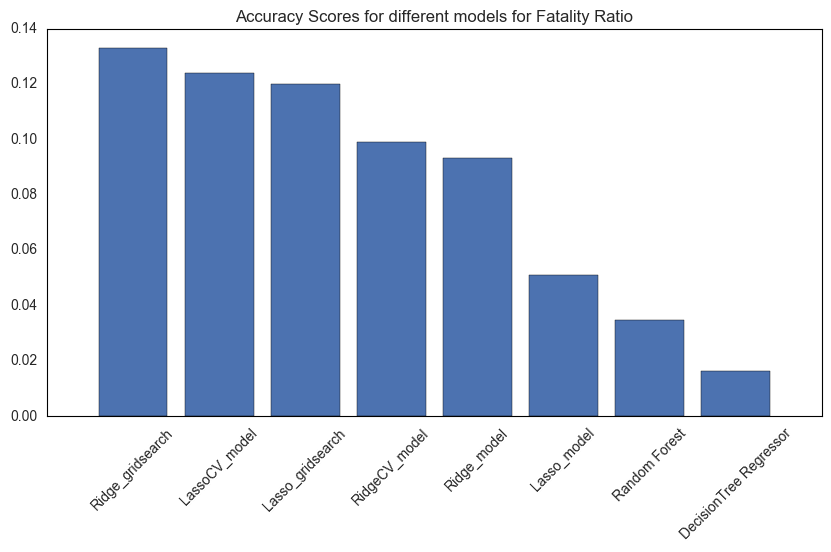

In [53]:
df_l_class = pd.DataFrame(linear_score.items(), columns=['Model', 'Score'])

df_l_class.sort(['Score'], ascending=[0], inplace=True)


plt.figure(figsize=(10,5))
plt.bar(range(len(df_l_class)), df_l_class['Score'], align='center')
#plt.axhline(0.65, color='black',linestyle='dashed')
#plt.ylim(0,0.8)
plt.xticks(range(len(df_l_class)), df_l_class['Model'],rotation=45)
plt.title('Accuracy Scores for different models for Fatality Ratio')
plt.show()

# Classification Analysis for Fatalities

As predicting extact fatalities ratio didn't give much of any performance result. So going to classify the fatalities by low, medium and high. For that looking at the Fatalities number in the data set and most of the fatalities count ranges between 0 to mean value. There are very less numbr of accidents where fataliteis are >100.

From the below analysis averge terms 20 people die on each crash and median is 9, which means most of the crashes fatalities range come closer to 9 people died. So there are very much rare occurrence of lot of people died which means less accidents to commercial airline, because commercial airlines are those wich carries more people on board and there are very less changes of those crashing these recent years. 

Most commonly it the flights which carry less passengers like miliary airplane, cargo plane with pilot, private jet or helicopters got crashed with less number of people.

Similar analysis also done for Survival Count so that it can can classify if accident happens all of them will die or some of them will die and no one will die for predicting.


In [54]:
print "Central Tendency meansures for Fatalities Count:"
print "------------------------------------------------"
print "Mean   :",df_all['Fatalities_num'].mean()
print "Minimum:",df_all['Fatalities_num'].min()
print "Maximum:",df_all['Fatalities_num'].max()
print "Median :",df_all['Fatalities_num'].median()

Central Tendency meansures for Fatalities Count:
------------------------------------------------
Mean   : 20.2098765432
Minimum: 0
Maximum: 583
Median : 9.0


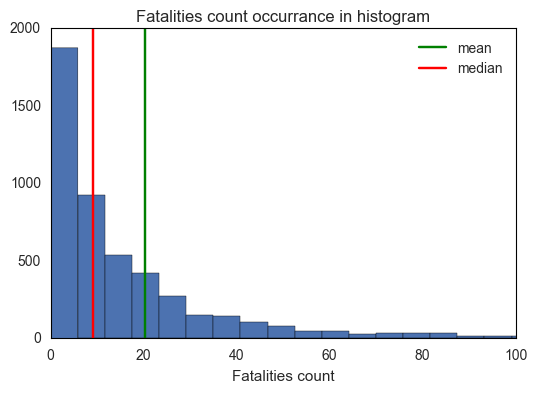

In [55]:
plt.hist(df_all['Fatalities_num'],bins=100)
plt.axvline(df_all['Fatalities_num'].mean(), color='g', label='mean')
plt.axvline(df_all['Fatalities_num'].median(), color='r', label='median')
plt.legend()
plt.title('Fatalities count occurrance in histogram')
plt.xlabel('Fatalities count')
plt.xlim(0,100)
plt.show()

 __Fatalities Classification__ like the below
 - Low Fatality (0 - 20 people died)
 - Medium Fatality ( 21 - 50 people died)
 - High Fatality  ( >50 people died)

In [162]:
# Function to classify Fatalities count by three classes (Low, Medium, High Fatalaties)
mappy = {'Low':range(0,21),'Medium':range(21,51),'High': range(51,584)}

def fatalities_classify(x):
    for i in mappy.keys():
        if x in mappy[i]:
            return i

In [163]:
df_all['Fatality_class'] = df_all['Fatalities_num'].map(fatalities_classify)

/Users/Reva/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


__Base line accuracy for Fatalities Classification__

In [164]:
df_all['Fatality_class'].value_counts()/len(df_all)

Low       0.719895
Medium    0.188828
High      0.091277
Name: Fatality_class, dtype: float64

## Logistic Regression Fatalities Classification

In [59]:
#Creating X and y for feeding into the model

In [60]:
X=df_all.drop(['Date','Ground','loccountry','Fatalities_num','Fatalities_ratio','Survived_num','Survival_ratio',
            'Manufacturer_ac_type','reason_crash','Fatality_class'], axis=1)

X = pd.concat([X, df_all_dummies], axis=1)
y = df_all['Fatality_class'].map({'Low':0,'Medium':1,'High':2})
y = np.ravel(y)

In [61]:
X=StandardScaler().fit_transform(X)

In [76]:
#splitting data into train and test
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.20,random_state=42)

In [63]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve

logreg = LogisticRegression(penalty='l1', C=1.0)
logreg.fit(X_train, y_train)

predictions = logreg.predict(X_test)
logreg_score = cross_val_score(logreg, X_test, y_test,cv=5,scoring='accuracy').mean()

print "Cross-Validation Accuracy score:",logreg_score

Cross-Validation Accuracy score: 0.749226067784


In [64]:
# creating dictionary to store each classification
score_class = {}
score_class['Logreg'] = logreg_score

In [65]:
cm1 = confusion_matrix(y_test, y_test)
cm2 = confusion_matrix(y_test, predictions)

In [66]:
def plot_confusion_matrix(cm, title='Confusion matrix', labels=['Low','Medium','High'], cmap=plt.cm.Blues):  
    plt.figure(figsize=(4,4))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)   
    tick_marks = np.arange(3)
    plt.xticks(tick_marks, labels)
    plt.yticks(tick_marks, labels)      
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    
    width, height = cm.shape
    
    for x in xrange(width):
        for y in xrange(height):
            plt.annotate(str(cm[x][y]), xy=(y, x), 
                        horizontalalignment='center',
                        verticalalignment='center',
                        color = 'black',
                        fontsize=18)
                #The last line here adds a text outline

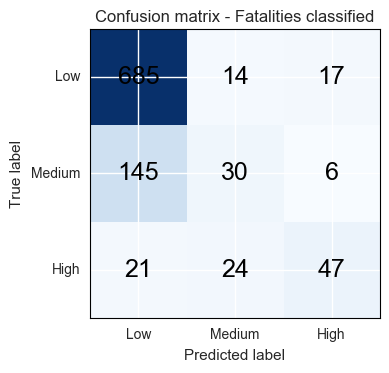

In [67]:
plot_confusion_matrix(cm2, title='Confusion matrix - Fatalities classified', labels=['Low','Medium','High'], cmap=plt.cm.Blues)

In [68]:
print classification_report(y_test, predictions)

             precision    recall  f1-score   support

          0       0.80      0.96      0.87       716
          1       0.44      0.17      0.24       181
          2       0.67      0.51      0.58        92

avg / total       0.73      0.77      0.73       989



## Random Forest Classifier

In [69]:
from sklearn.ensemble import RandomForestClassifier

In [70]:
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [71]:
y_pred = rfc.predict(X_test)

In [72]:
rfc_score = accuracy_score(y_test, y_pred)
print "Random forest accuracy score:",rfc_score

score_class['Random Forest'] = rfc_score

Random forest accuracy score: 0.868554095046


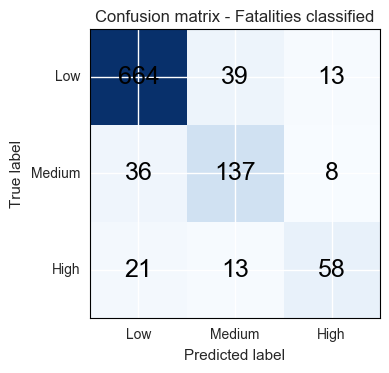

In [73]:
cm_ran = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm_ran, title='Confusion matrix - Fatalities classified', labels=['Low','Medium','High'], cmap=plt.cm.Blues)

In [74]:
print classification_report(y_test, y_pred)

             precision    recall  f1-score   support

          0       0.92      0.93      0.92       716
          1       0.72      0.76      0.74       181
          2       0.73      0.63      0.68        92

avg / total       0.87      0.87      0.87       989



ROC curve and roc_auc score for multiple class has to in in the multiple class format which is computed used label_binarizer where it will create mutliple class. Example in this case there are 3 classes (low, medium, high). Label binarizer will compute single dimensional array into three dimensional array and will make column for each class and it will provide much better result. 

The same can be implemented using sklearn.multiclass.OneVsRestClassifier method. This can be achieved with SVM and other model, which I might dig deep into this when I finialise which model is performing better.


http://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.h

In [75]:
y_test = label_binarize(y_test, classes=[0, 1, 2])
y_pred = label_binarize(y_pred, classes=[0, 1, 2])
print "roc area under the curve for Random Forest:",roc_auc_score(y_test , y_pred)

roc area under the curve for Random Forest: 0.83635935766


## Gradiant Boosting Classifier

In [85]:
from sklearn.ensemble import GradientBoostingClassifier
gbc = GradientBoostingClassifier()
#gbc.fit(X_train, y_train)

In [86]:
cs_train = cross_val_score(gbc, X_train, y_train, cv=5)
print cs_train
print cs_train.mean()

[ 0.90025253  0.88369153  0.89367089  0.88227848  0.87198986]
0.886376656527


In [87]:
gbc.fit(X_train, y_train)
y_pred = gbc.predict(X_test)

In [88]:
y_pred = gbc.predict(X_test)
gbc_score = accuracy_score(y_test, y_pred)
print "Gradiant Boosting Classifier:", gbc_score
score_class['Gradiant Boost'] = gbc_score

Gradiant Boosting Classifier: 0.904954499494


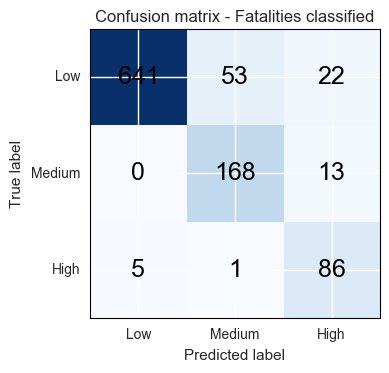

In [89]:
cm_gbc = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm_gbc, title='Confusion matrix - Fatalities classified', labels=['Low','Medium','High'], cmap=plt.cm.Blues)

In [90]:
print classification_report(y_test, y_pred)

             precision    recall  f1-score   support

          0       0.99      0.90      0.94       716
          1       0.76      0.93      0.83       181
          2       0.71      0.93      0.81        92

avg / total       0.92      0.90      0.91       989



In [91]:
#roc_auc_score(y_test,y_pred)

## XGBClassifier

In [92]:
from xgboost import XGBClassifier
xgbc = XGBClassifier()
xgbc.fit(X_train, y_train)

XGBClassifier(base_score=0.5, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=100, nthread=-1, objective='multi:softprob', seed=0,
       silent=True, subsample=1)

In [93]:
y_pred = xgbc.predict(X_test)
xgbc_score = accuracy_score(y_test, y_pred)
print "Gradiant Boosting Classifier:", xgbc_score
score_class['XGBoost Classifier'] = xgbc_score

Gradiant Boosting Classifier: 0.903943377149


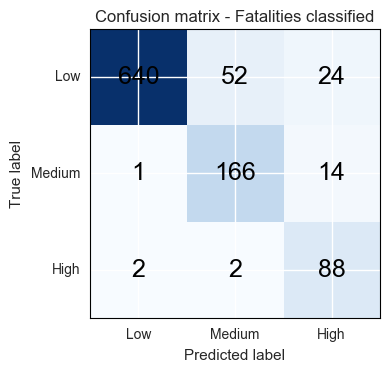

In [94]:
cm_xgbc = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm_xgbc, title='Confusion matrix - Fatalities classified', labels=['Low','Medium','High'], cmap=plt.cm.Blues)

In [95]:
print classification_report(y_test, y_pred)

             precision    recall  f1-score   support

          0       1.00      0.89      0.94       716
          1       0.75      0.92      0.83       181
          2       0.70      0.96      0.81        92

avg / total       0.92      0.90      0.91       989



## Support Vector Machine

In [96]:
from sklearn.svm import SVC

all_scores = []
model = SVC(kernel='rbf')

scores = cross_val_score(model, X_train, y_train, cv=5)
scores

array([ 0.72727273,  0.72692794,  0.74683544,  0.72531646,  0.72116603])

In [97]:
score_class['SVM model'] = scores.mean()

In [98]:
print score_class

{'SVM model': 0.7295037196554659, 'XGBoost Classifier': 0.90394337714863493, 'Gradiant Boost': 0.90495449949443885, 'Random Forest': 0.86855409504550052, 'Logreg': 0.74922606778444345}


## KNN Classifier

In [99]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()

print 'Cross validated accuracy scores KNN 3 neighbours:', cross_val_score(knn, X, y, cv=3)
print 'Mean cross validated accuracy:', cross_val_score(knn, X, y, cv=3).mean()

Cross validated accuracy scores KNN 3 neighbours: [ 0.65533981  0.70673953  0.69501823]
Mean cross validated accuracy: 0.68569918608


In [100]:
gs_knn = GridSearchCV(knn, {'n_neighbors': range(1, 11)})
gs_knn.fit(X,y)

print 'Regression parameters:', gs_knn.best_params_, '\n'

print 'Cross validated accuracy KNN 10 neighbours:', gs_knn.best_score_

Regression parameters: {'n_neighbors': 10} 

Cross validated accuracy KNN 10 neighbours: 0.708561020036


In [102]:
score_class['KNN model'] = gs_knn.best_score_

## LDA Model

In [103]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis(n_components=2)

X_lda = lda.fit_transform(X, y)
lda.explained_variance_ratio_

array([ 0.83861443,  0.16138557])

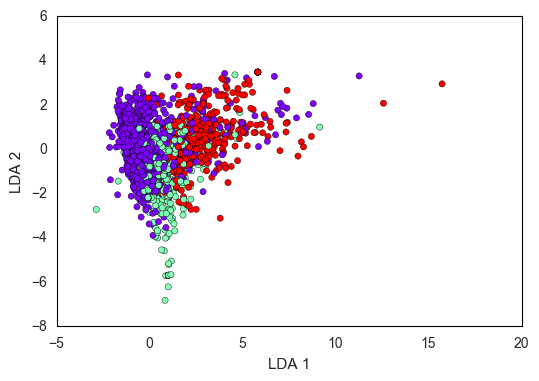

In [104]:
plt.scatter(X_lda[:,0], X_lda[:,1], c=y, cmap='rainbow')
plt.xlabel('LDA 1')
plt.ylabel('LDA 2')
plt.show()

In [105]:
print 'Cross validated accuracy scores LDA:', cross_val_score(lda, X, y, cv=3)
print 'Mean cross validated accuracy:', cross_val_score(lda, X, y, cv=3).mean()

Cross validated accuracy scores LDA:

/Users/Reva/anaconda/lib/python2.7/site-packages/sklearn/discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


 [ 0.62135922  0.72981178  0.71871203]
Mean cross validated accuracy: 0.689961010485


             precision    recall  f1-score   support

          0       0.74      0.91      0.82      3557
          1       0.18      0.05      0.08       933
          2       0.40      0.29      0.34       451

avg / total       0.60      0.69      0.63      4941



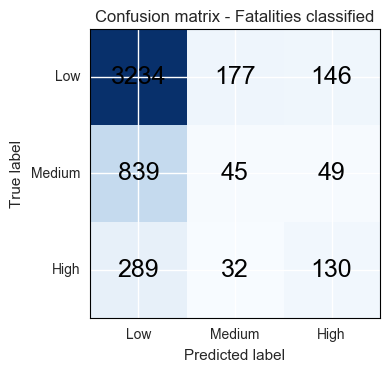

In [106]:
cm_lda = confusion_matrix(y, cross_val_predict(lda, X, y, cv=3))
plot_confusion_matrix(cm_lda, title='Confusion matrix - Fatalities classified', labels=['Low','Medium','High'], cmap=plt.cm.Blues)
print classification_report(y, cross_val_predict(lda, X, y, cv=3))

In [107]:
score_class['LDA model'] =  cross_val_score(lda, X, y, cv=3).mean()

## Choosing the Model and its Metrics

/Users/Reva/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  app.launch_new_instance()


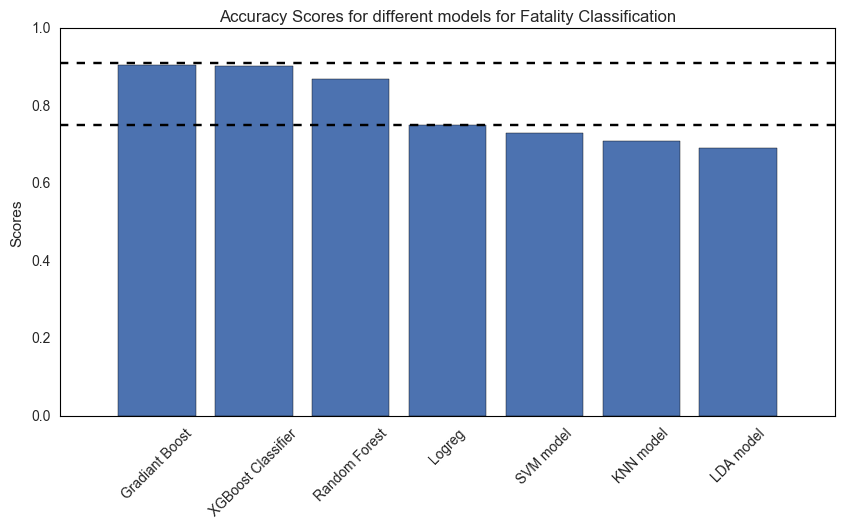

In [115]:
df_f_class = pd.DataFrame(score_class.items(), columns=['Model', 'Score'])

df_f_class.sort(['Score'], ascending=[0], inplace=True)


plt.figure(figsize=(10,5))
plt.bar(range(len(df_f_class)), df_f_class['Score'], align='center')
plt.axhline(0.75, color='black',linestyle='dashed')
plt.axhline(0.91, color='black',linestyle='dashed')
#plt.ylim(0,0.8)
plt.xticks(range(len(df_f_class)), df_f_class['Model'],rotation=45)
plt.title('Accuracy Scores for different models for Fatality Classification')
plt.ylabel('Scores')
plt.show()


## Metric Analysis
After using classification techniques for Fatalities (low, medium, high). The model was able to predict whether the fatality would low, medium and high based on the crash location, reason and manufacture type of the aircraft. Using 7 models (KNN, Gradiant Boost, Logistic regression, LDA, SVM and Random Forest). The best score model is Gradiant Boost which was providing score 0.905. 

Next step is trying the similar models for Survival Ratio. Also plotting precision curve for best model which is gradiant boost and also ROC curve for that model


## PRECISION-RECALL and ROC Curve (Gradiant Boost Model)

In [116]:
from sklearn.metrics import precision_recall_curve

In [117]:
#function to show precision and recall for multiple class along with overall precision and recall
def precision_recallcurve(model, y_test, y_pred, X_test1):
    
    y_test1 = label_binarize(y_test, classes=[0, 1, 2])
    y_pred1 = label_binarize(y_pred, classes=[0, 1, 2])
    y_score1 = model.decision_function(X_test1)
    n_classes=3
    lw=2
    # Compute Precision-Recall and plot curve
    precision = dict()
    recall = dict()
    average_precision = dict()
    for i in range(n_classes):
        precision[i], recall[i], _ = precision_recall_curve(y_test1[:, i],
                                                            y_score1[:, i])
        average_precision[i] = average_precision_score(y_test1[:, i], y_score1[:, i])

    # Compute micro-average ROC curve and ROC area
    precision["micro"], recall["micro"], _ = precision_recall_curve(y_test1.ravel(),
        y_score1.ravel())
    average_precision["micro"] = average_precision_score(y_test1, y_score1,
                                                         average="micro")
    # Plot Precision-Recall curve for each class
    plt.figure(figsize=(8,6))
    plt.clf()
    plt.plot(recall["micro"], precision["micro"], color='navy', lw=lw,
             label='micro-average Precision-recall curve (area = {0:0.2f})'
                   ''.format(average_precision["micro"]))
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
    for i, color in zip(range(n_classes), colors):
        if i==0:
            class__='Low'
        elif i==2:
            class__='Medium'
        else:
            class__='High'
        plt.plot(recall[i], precision[i], color=color, lw=lw,
                 label='Precision-recall curve of class {0} (area = {1:0.2f})'
                       ''.format(class__, average_precision[i]))

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall curve to multi-class')
    plt.legend(loc="lower right")
    plt.show()
    
    return


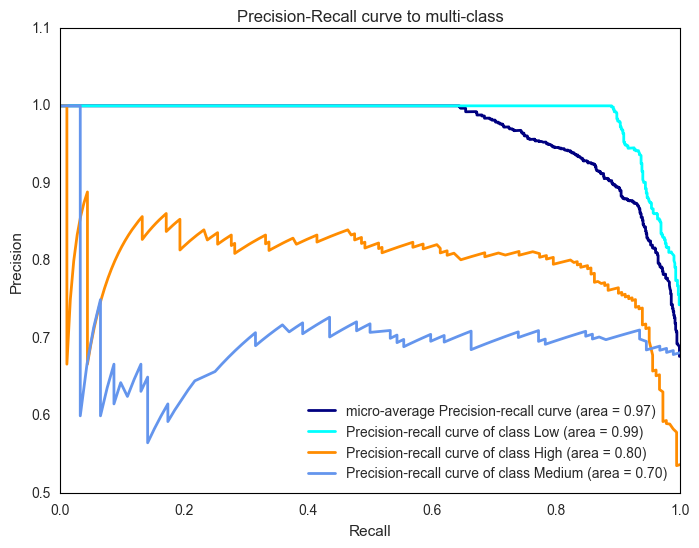

In [118]:
precision_recallcurve(gbc, y_test, y_pred, X_test)

In [119]:
#function to show roc for multiple class and 
def roc_curves(model,y_test2, y_pred2, X_test2):
    lw =2

    # Binarize the output
    y_test2 = label_binarize(y_test2, classes=[0, 1, 2])
    n_classes = y_test2.shape[1]

    y_score2 = model.decision_function(X_test2)

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test2[:, i], y_score2[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test2.ravel(), y_score2.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # Compute micro-average ROC curve and ROC area
    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    plt.figure(figsize=(8,6))
    plt.plot(fpr["micro"], tpr["micro"],
             label='micro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["micro"]),
             color='deeppink', linestyle=':', linewidth=4)

    plt.plot(fpr["macro"], tpr["macro"],
             label='macro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["macro"]),
             color='navy', linestyle=':', linewidth=4)

    colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic(ROC) to multi-class')
    plt.legend(loc="lower right")
    plt.show()
    return

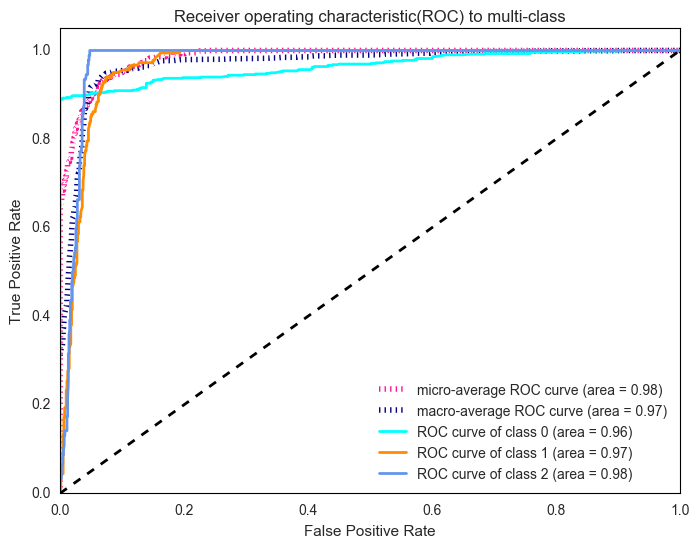

In [120]:
roc_curves(gbc, y_test, y_pred, X_test)

# Classification Analysis for Survivals

In [121]:
print "Central Tendency meansures for Survival Count:"
print "------------------------------------------------"
print "Mean   :",df_all['Survived_num'].mean()
print "Minimum:",df_all['Survived_num'].min()
print "Maximum:",df_all['Survived_num'].max()
print "Median :",df_all['Survived_num'].median()

Central Tendency meansures for Survival Count:
------------------------------------------------
Mean   : 8.02165553532
Minimum: 0
Maximum: 516
Median : 0.0


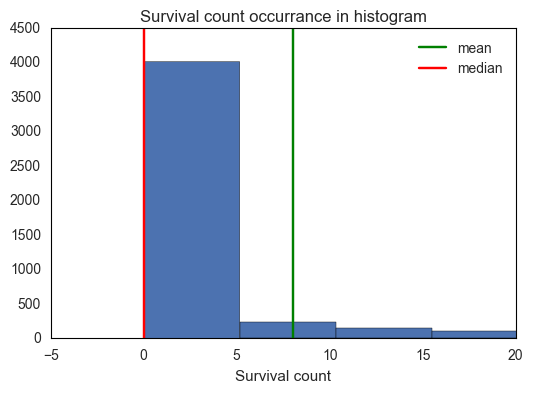

In [122]:
plt.hist(df_all['Survived_num'],bins=100)
plt.axvline(df_all['Survived_num'].mean(), color='g', label='mean')
plt.axvline(df_all['Survived_num'].median(), color='r', label='median')
plt.legend()
plt.title('Survival count occurrance in histogram')
plt.xlabel('Survival count')
plt.xlim(-5,20)
plt.show()

In [123]:
#Below function to classify the survival ratio as the following three classes
# - All of them survived
# - None of them survived
# - Some of them survied

In [165]:
def survival(row):
    if row['Survived_num'] == row['Aboard_num']:
        val = 'All_survived'
    elif row['Survived_num']<>0:
        val = 'None_survived'
    elif (row[(row['Survived_num']<>0) & (row['Survived_num']!=row['Aboard_num'])]):
        val = 'Some_survived'
    return val

In [166]:
df_all['Survial_class'] = df.apply(survival, axis=1)

/Users/Reva/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [167]:
# Creating X and y for survival classification

In [168]:
X=df_all.drop(['Date','Ground','loccountry','Fatalities_num','Fatalities_ratio','Survived_num','Survival_ratio',
            'Manufacturer_ac_type','reason_crash','Survial_class','Fatality_class'], axis=1)

X = pd.concat([X, df_all_dummies], axis=1)
y = df_all['Survial_class'].map({'All_survived':0,'None_survived':1,'Some_survived':2})
y = np.ravel(y)

In [169]:
X=StandardScaler().fit_transform(X)

In [170]:
#splitting data into train and test
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.20,random_state=42)

__Baseline accuracy for Survival class__

In [171]:
df_all['Survial_class'].value_counts()/len(df_all)

Some_survived    0.652297
None_survived    0.334750
All_survived     0.012953
Name: Survial_class, dtype: float64

## Logistic Regression

In [215]:
logreg = LogisticRegression()
logreg_score = cross_val_score(logreg, X_train, y_train,cv=5,scoring='accuracy').mean()

print "Cross-Validation Accuracy score for Train Set:",logreg_score

Cross-Validation Accuracy score for Train Set: 0.663474222014


In [216]:
gs_logreg = GridSearchCV(logreg, {'C': [0.001,0.1, 0.2,0.5,0.6,1,], 'penalty':['l1','l2']})
gs_logreg.fit(X_train,y_train)

print 'Grid Search best parameters:', gs_logreg.best_params_, '\n'

print 'Cross validated accuracy logistic regression:', gs_logreg.best_score_

Grid Search best parameters: {'penalty': 'l1', 'C': 0.5} 

Cross validated accuracy logistic regression: 0.667763157895


In [217]:
y_predtt = gs_logreg.best_estimator_.predict(X_test)
log_scoret=accuracy_score(y_test, y_predtt)
print 'Accuracy score for Test set:', log_scoret

Accuracy score for Test set: 0.673407482305


In [175]:
cm_lrs=confusion_matrix(y_test, y_predtt)
print classification_report(y_test, y_predtt)

             precision    recall  f1-score   support

          0       0.00      0.00      0.00        11
          1       0.54      0.30      0.38       328
          2       0.71      0.88      0.78       650

avg / total       0.64      0.67      0.64       989



In [176]:
score_s_class={}
score_s_class['log_reg']=log_scoret

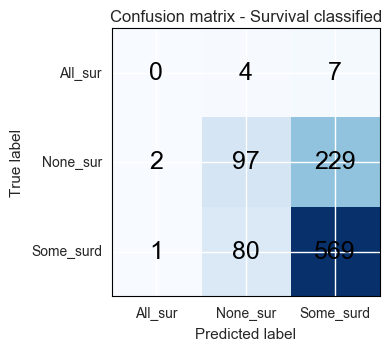

In [177]:
plot_confusion_matrix(cm_lrs, title='Confusion matrix - Survival classified', labels=['All_sur','None_sur','Some_surd'], cmap=plt.cm.Blues)

## Random Forest Classifier

In [178]:
rfc = RandomForestClassifier(max_depth=10)
print cross_val_score(rfc, X_train, y_train,cv=5,scoring='accuracy')
rfc_score = cross_val_score(rfc, X_train, y_train,cv=5,scoring='accuracy').mean()

print "Cross-Validation Accuracy score for Train set:",rfc_score

[ 0.66792929  0.65865992  0.66624526  0.67046895  0.64892269]
Cross-Validation Accuracy score for Train set: 0.663968055136


In [179]:
rfc.fit(X_train, y_train)
y_predtt = rfc.predict(X_test)
rfc_scoret=accuracy_score(y_test, y_predtt)
print 'Accuracy score for Test set:', rfc_scoret

Accuracy score for Test set: 0.654196157735


In [181]:
cm_rfc=confusion_matrix(y_test, y_predtt)
print classification_report(y_test, y_predtt)

             precision    recall  f1-score   support

          0       0.00      0.00      0.00        11
          1       0.45      0.08      0.14       328
          2       0.67      0.95      0.79       650

avg / total       0.59      0.65      0.56       989



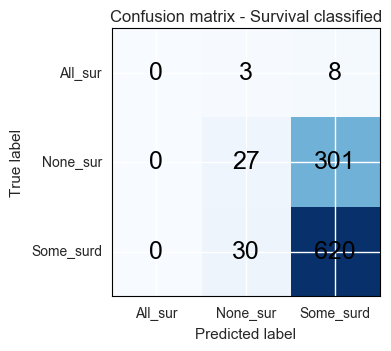

In [182]:
plot_confusion_matrix(cm_rfc, title='Confusion matrix - Survival classified', labels=['All_sur','None_sur','Some_surd'], cmap=plt.cm.Blues)

In [183]:
score_s_class['Random Forest']=rfc_scoret

## Gradiant Boosting Classifier

In [184]:
gbc = GradientBoostingClassifier()
cs_score = cross_val_score(gbc, X_train, y_train,cv=5,scoring='accuracy')
print cs_score
gbc_score = cs_score.mean()

print "Cross-Validation Accuracy score for Train:",gbc_score

[ 0.69570707  0.68015171  0.65992415  0.69708492  0.68567807]
Cross-Validation Accuracy score for Train: 0.683709183037


In [185]:
gbc.fit(X_train, y_train)
y_predtt = gbc.predict(X_test)
gbc_scoret=accuracy_score(y_test, y_predtt)
print 'Accuracy score for Test set:', gbc_scoret

Accuracy score for Test set: 0.69160768453


In [186]:
score_s_class['Gradiant Boost']=gbc_scoret

In [187]:
cm_gbc=confusion_matrix(y_test,y_predtt)
print classification_report(y_test, y_predtt)

             precision    recall  f1-score   support

          0       0.33      0.18      0.24        11
          1       0.57      0.35      0.43       328
          2       0.73      0.87      0.79       650

avg / total       0.67      0.69      0.67       989



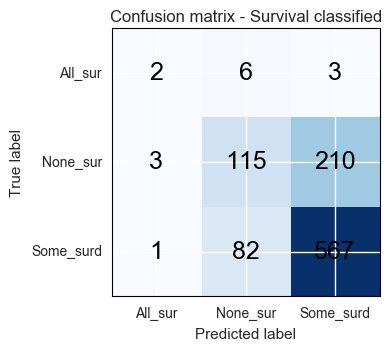

In [188]:
plot_confusion_matrix(cm_gbc, title='Confusion matrix - Survival classified', labels=['All_sur','None_sur','Some_surd'], cmap=plt.cm.Blues)

## XGBoost Classifier

In [189]:
xgbc = XGBClassifier()
cs_score = cross_val_score(xgbc, X_train, y_train,cv=5,scoring='accuracy')
print cs_score
xgbc_score = cs_score.mean()

print "Cross-Validation Accuracy score for Train set:",xgbc_score

[ 0.69823232  0.68773704  0.67509482  0.69074778  0.70215463]
Cross-Validation Accuracy score for Train set: 0.69079331795


In [190]:
xgbc.fit(X_train, y_train)
y_predtt = xgbc.predict(X_test)
xgbc_scoret=accuracy_score(y_test, y_predtt)
print 'Accuracy score for Test set:', xgbc_scoret

Accuracy score for Test set: 0.69868554095


In [191]:
score_s_class['XGBoost Class']=xgbc_scoret

In [192]:
cm_xgbc=confusion_matrix(y_test, y_predtt)
print classification_report(y_test, y_predtt)

             precision    recall  f1-score   support

          0       0.00      0.00      0.00        11
          1       0.58      0.39      0.47       328
          2       0.73      0.87      0.80       650

avg / total       0.68      0.70      0.68       989



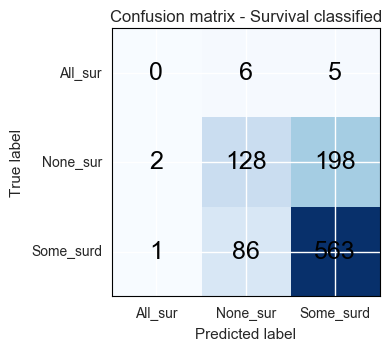

In [193]:
plot_confusion_matrix(cm_xgbc, title='Confusion matrix - Survival classified', labels=['All_sur','None_sur','Some_surd'], cmap=plt.cm.Blues)

## SVM Model

In [194]:
svc = SVC(kernel='rbf')

cs_score = cross_val_score(svc, X_train, y_train,cv=5,scoring='accuracy')
print cs_score
svc_score = cs_score.mean()

print "Cross-Validation Accuracy score for Train set:",svc_score

[ 0.63888889  0.65233881  0.64981037  0.65272497  0.65019011]
Cross-Validation Accuracy score for Train set: 0.648790629905


In [195]:
svc.fit(X_train, y_train)
y_predtt = svc.predict(X_test)
svc_scoret=accuracy_score(y_test, y_predtt)
print 'Accuracy score for Test set:', svc_scoret

Accuracy score for Test set: 0.652173913043


In [196]:
score_s_class['SVM Model']=svc_scoret

In [197]:
cm_svc=confusion_matrix(y_test, y_predtt)
print classification_report(y_test, y_predtt)

             precision    recall  f1-score   support

          0       0.00      0.00      0.00        11
          1       0.45      0.12      0.20       328
          2       0.67      0.93      0.78       650

avg / total       0.59      0.65      0.58       989



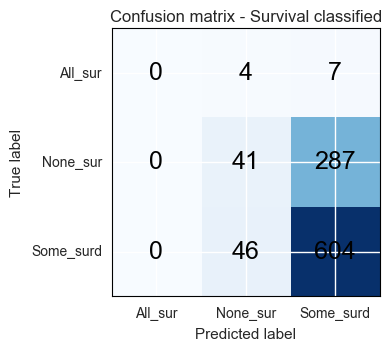

In [198]:
plot_confusion_matrix(cm_svc, title='Confusion matrix - Survival classified', labels=['All_sur','None_sur','Some_surd'], cmap=plt.cm.Blues)

## KNN Classifier

In [200]:
knn = KNeighborsClassifier(n_neighbors=5)

cs_score = cross_val_score(knn, X_train, y_train,cv=5,scoring='accuracy')
print cs_score
knn_score = cs_score.mean()

print 'Mean cross validated accuracy for 5 neighbours:', knn_score

[ 0.62247475  0.62452592  0.61441214  0.60583016  0.6400507 ]
Mean cross validated accuracy for 5 neighbours: 0.621458732485


In [201]:
knn.fit(X_train, y_train)
y_predtt = knn.predict(X_test)
knn_scoret=accuracy_score(y_test, y_predtt)
print 'Accuracy score for Test set:', knn_scoret

Accuracy score for Test set: 0.629929221436


In [202]:
score_s_class['KNN Model']=knn_scoret

In [203]:
cm_knn=confusion_matrix(y_test, y_predtt)
print classification_report(y_test, y_predtt)

             precision    recall  f1-score   support

          0       0.25      0.09      0.13        11
          1       0.44      0.37      0.40       328
          2       0.71      0.77      0.74       650

avg / total       0.61      0.63      0.62       989



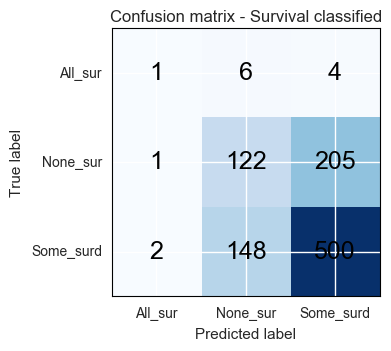

In [204]:
plot_confusion_matrix(cm_knn, title='Confusion matrix - Survival classified', labels=['All_sur','None_sur','Some_surd'], cmap=plt.cm.Blues)

## LDA Model

In [205]:
lda = LinearDiscriminantAnalysis(n_components=2)

X_lda = lda.fit_transform(X, y)
lda.explained_variance_ratio_

array([ 0.69909097,  0.30090903])

In [206]:
lda

LinearDiscriminantAnalysis(n_components=2, priors=None, shrinkage=None,
              solver='svd', store_covariance=False, tol=0.0001)

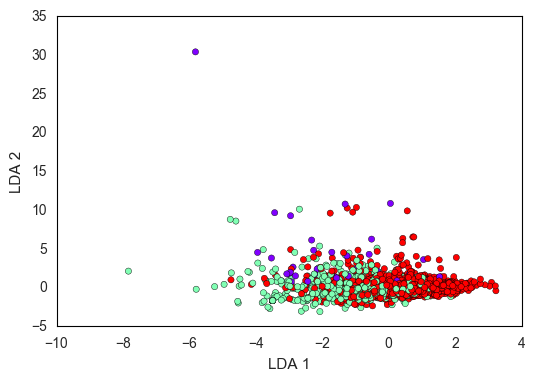

In [207]:
plt.scatter(X_lda[:,0], X_lda[:,1], c=y, cmap='rainbow')
plt.xlabel('LDA 1')
plt.ylabel('LDA 2')
plt.show()

In [208]:
cs_score = cross_val_score(lda, X_train, y_train,cv=5,scoring='accuracy')
print cs_score
lda_score = cs_score.mean()

print 'Mean cross validated accuracy:', lda_score

[ 0.65025253  0.64981037  0.02022756  0.67427123  0.56147022]
Mean cross validated accuracy: 0.511206379359


In [209]:
lda.fit(X_train, y_train)
y_predtt = lda.predict(X_test)
lda_scoret=accuracy_score(y_test, y_predtt)
print 'Accuracy score for Test set:', lda_scoret

Accuracy score for Test set: 0.0222446916077


In [210]:
score_s_class['LDA Model']=lda_scoret

In [211]:
cm_lda=confusion_matrix(y_test, y_predtt)
print classification_report(y_test, y_predtt)

             precision    recall  f1-score   support

          0       0.01      0.91      0.02        11
          1       1.00      0.01      0.01       328
          2       0.77      0.02      0.03       650

avg / total       0.84      0.02      0.02       989



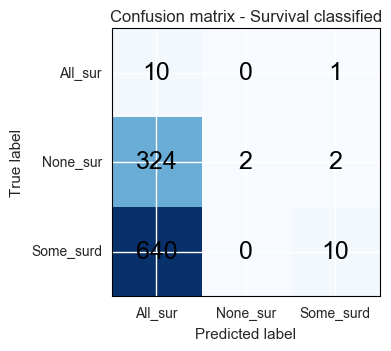

In [212]:
plot_confusion_matrix(cm_lda, title='Confusion matrix - Survival classified', labels=['All_sur','None_sur','Some_surd'], cmap=plt.cm.Blues)

## Choosing the Model and its metrics

/Users/Reva/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  app.launch_new_instance()


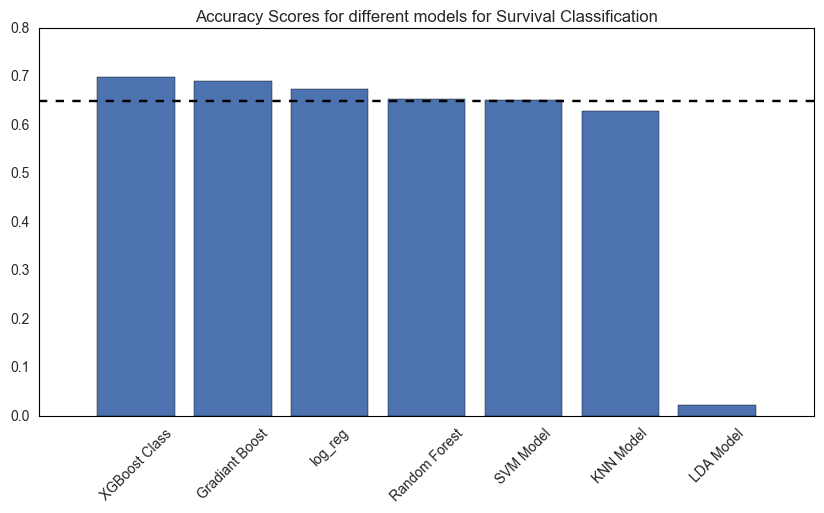

In [214]:
df_s_class = pd.DataFrame(score_s_class.items(), columns=['Model', 'Score'])

df_s_class.sort(['Score'], ascending=[0], inplace=True)


plt.figure(figsize=(10,5))
plt.bar(range(len(df_s_class)), df_s_class['Score'], align='center')
plt.axhline(0.65, color='black',linestyle='dashed')
plt.ylim(0,0.8)
plt.xticks(range(len(df_s_class)), df_s_class['Model'],rotation=45)
plt.title('Accuracy Scores for different models for Survival Classification')
plt.show()


## Metrics and its analysis

For every aircrash based on location, date, aircraft type, reason for crash and how many people boarded on the airplane, the model could predict if all of them survived, none of them survived or some of them survied. In this case the base line is 0.65.

After applying the same 7 model applied for fatality classification (logistic regression, gradiant boost, Knn, LDA, Random Forest, SVM model), the best is Logistic regression its score is 0.66 which is just above the baseline accuracy. So this is the best model.

## PRECISION-RECALL and ROC Curve (Logistic Regression Model)

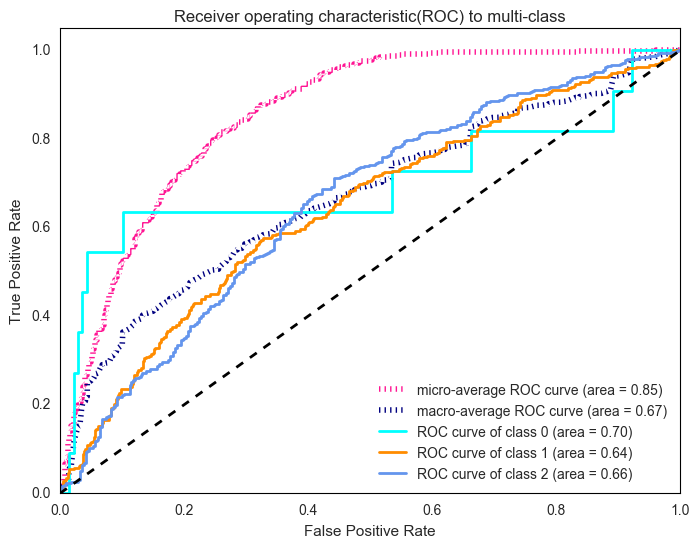

In [219]:
roc_curves(gs_logreg.best_estimator_,y_test, y_predtt, X_test)

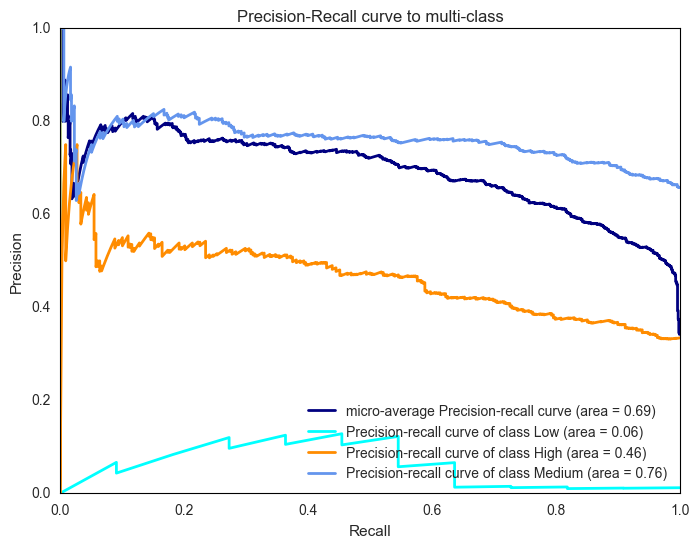

In [220]:
precision_recallcurve(gs_logreg.best_estimator_, y_test, y_predtt, X_test)

In [226]:
#Function to return base map for given dataframe
def basemap_crash(dff):

    plt.figure(figsize=(20, 10))

    # Create a map on which to draw.  We're using a mercator projection, and showing the whole world.
    m = Basemap(projection='merc',llcrnrlat=-80,urcrnrlat=80,llcrnrlon=-180,urcrnrlon=180,lat_ts=20,resolution='c')
    # Draw coastlines, and the edges of the map.
    m.drawcoastlines()
    m.drawmapboundary()
    # Convert latitude and longitude to x and y coordinates
    x, y = m(list(dff["longititude"].astype(float)), list(dff["latitude"].astype(float)))
    # Use matplotlib to draw te points onto the map.
    m.scatter(x,y,1,marker='o',color='red')
    # Show the plot.
    plt.show()
    
    return

In [230]:
import folium

# Get a basic world map.
airports_map = folium.Map(location=[30, 0], zoom_start=2,tiles=u'OpenStreetMap')
# Draw markers on the map.
for name, row in dff.iterrows():
    airports_map.circle_marker(location=[row["latitude"], row["longititude"]])
# Create and show the map.
airports_map.create_map('airports.html')
airports_map

/Users/Reva/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:7: FutureWarning: circle_marker is deprecated. Use add_children(CircleMarker) instead
/Users/Reva/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:9: FutureWarning: Map.create_map is deprecated. Use Map.save instead


# Technical Analysis

## 6.1 Executive Summary

The project is about analysing, exploring and finding any interesting trends in the aviation accidents (airplane crashes) occured from 1921 till 2016 (August). Over 95 years airplance crash data including military transport accidents, cargo flights, commercial accidents, private jet and helicopter accidents. This also includes world war-II accidents crashes (1939 - 1945). After dropping some NA values and the below figures are considered for analysis

- 4941 crashes
- 99,857 fatalities
- 139,492 aboarded
- 39,635 survived
- 249 countries
- 42 Manufacturer Aircraft Types

General hypothesis is that commerical airlines crash happens very rarely. Safety of airplane increased and apart from few crime incidents like hijack, terrorism, human errors and mechanical issues of airplance, the accidents are very rare. But recent days with German wings crash incident, Malaysian airline crash in ukraine, missing MH370 makes us re-question the safety of flying. 

With the dataset I have which includes date, location, manufacturer aircraft type and airlines, going to explore the following goals.

1. Which airlines are not safer to flywith and has it reduced in recent decades
2. Which manufactures aircraft types are dangerous to fly with
3. As predicting the fatality ratio with availabe set is very difficult and it hasn't resulted in good results. So converted into classification prorblem. Going to predict the fatality class/range like 
    - __Low Fatality__ (fatalities per accident is less than mean fatalitity (<=20)
    - __Medium Fatality__ (fatalities per accident is between 21 and 50
    - __High Fatality__ (fatalities per accident is higher than 51
      
4. Also predicting the survival class based on the available data
    - __All Survived__ 
    - __None Survived__
    - __Some of them Survived__

## 6.2 Identification of outliers

While performing linear regression model of predicting fatality ratio, had to deal with outliers with 9/11 incident where 2750 people died including 157 people on board (65+92) from two boeing aircrafts. After converting this into classification issue any fatalities above 51 are considered as hight fatalities range and there wasn't any need to drop or manipulate the outliers in this case.

__StackHolders__


## 6.3 Description of how you defined your variables

After dropping some of the columns (like Time, Flight number, Route of the flight, Registration numbers, Cn / In some numbers) which are not necessary for the analysis or modelling for this project and the below are the final features considered for this project.

1. __Date__: Date of accident, in the format - January 11, 2011
    - Extracted Year, Month and Day from this feature for more usual for analysis and modeling
2. __Location__: Location of the crash
    - Place where the accident occurred was very useful feature. But there are 4627 places which are not properly described in the dataset. Some of them like __900 miles E of Honolulu, Hawaii, Pacific Ocean__, so its best to convert these places into useful information. The only way to do is retriving meaning information as of latitude and longitude which will be more helpful in plotting for visualisation and also feeding into the model.
    - I used Free Google geocoding API(https://developers.google.com/maps/documentation/geocoding/intro) which comes with following usage limits
        - 2,500 free requests per day 
        - 10 requests per second.
    - As I had 5500+ locations to retrive data, had to use __try and except__ exception method to retrieve as some the places were not retrieving any infomation because the place names like __USSR , Czechoslovakia, etc__ these names were old or Czechoslovakia was separated into Czech and slovakia and Google Geocoding API was returing exception to these kind of places and nearly 450 rows were like this and was dropped. Due to API limit usage had to split the dataset into 3 sets and had to do for 3 days.
    - As I didn't had proper country names in the dataset, using goople API which returns Geo JSON file which contains multiple datapoints like lat,lng,country, full address. So I have extracted the appropriate country names as well.

3. __Airline/Operator__: Airline or operator of the aircraft
4. __AC Type__: Aircraft type
    - There were 2661 aircraft types in the original data set, which included multiple types of Douglas (DC-3, C-47A, DC-4, C-47B, DC-6B, etc) as different types rather than just one aircraft type as Douglas. So it was tedious and time consuming job to classify or group them into one manufacturer.
    - Created dictionaries for various aircraft manufacturers type using Wikipedia. There are 42 types like the below and nearly 500 where classified as unknown or None as there were not able to find in wikipedia and those were tiny aircraft types like helicopter, jet and private jet manufacturer by desginer and which are very rare accidents)

5. __Aboard__: Total aboard (Total: passengers / crew)
    - Extracted new column for Aboard numbers only
6. __Fatalities__: Total fatalities aboard (Total: passengers / crew)
    - Extracted new column for Fatalities numbers only
7. __Ground__: Total killed on the ground
8. __Summary__: Brief description of the accident and cause if known
    - As its description and using natural language processing (CountVectorizer). Classified as major 11 reasons which are below 
        - landing-takeoff       
        - weather conditions   
        - None or unknown                 
        - pilot error           
        - shot down              
        - engine error          
        - stall                   
        - due to fire             
        - others-cargo            
        - fuel exhaustion         
        - terrorism               
        - others-missing     
        
9. Categorical variables (Reasons for crash, Manufacturers Air craft type were converted into dummies and the below were the important features among 200 variables
        
        
__Feature Importance__
The below are the important features which were very important for any of the models

In [24]:
from sklearn.feature_selection import SelectKBest, f_classif

selector = SelectKBest(f_classif, k=10)
selected_data = selector.fit_transform(X, y)
kbest_columns = X.columns[selector.get_support()]
Xtbest = pd.DataFrame(selected_data, columns=kbest_columns)
Xtbest.head()

Aboard_num  Ghana  Guantánamo Bay  United States  Airbus  Boeing  \
0        46.0    0.0             0.0            0.0     0.0     0.0   
1         5.0    0.0             0.0            0.0     0.0     0.0   
2         3.0    0.0             0.0            0.0     0.0     0.0   
3         5.0    0.0             0.0            0.0     0.0     0.0   
4        45.0    0.0             0.0            1.0     0.0     0.0   

   engine error  landing-takeoff  pilot error  weather conditions  
0           1.0              0.0          0.0                 0.0  
1           0.0              0.0          0.0                 0.0  
2           0.0              1.0          0.0                 0.0  
3           0.0              0.0          0.0                 0.0  
4           0.0              0.0          0.0                 0.0

In [25]:
pd.DataFrame({'columns':X.columns, 'p_values':selector.pvalues_}).sort_values('p_values').head(10)

columns      p_values
5            Aboard_num  7.267943e-61
298     landing-takeoff  7.836436e-39
305  weather conditions  4.950365e-27
93       Guantánamo Bay  2.140416e-17
256              Airbus  4.739058e-13
261              Boeing  6.481597e-11
296        engine error  9.289180e-10
301         pilot error  1.054069e-06
85                Ghana  1.522749e-06
239       United States  1.559946e-06

## 6.4 Discussion of model selection and implementation

Initially fatality ratio was the predictive model which is linear regression and the below models were used 
    - Linear Regression
    - Lasso
    - Ridge
    - LassoCV
    - RidgeCV
Finally its been discovered that LassoCV model was best with just 0.2% accuracy. But its not best in predicting exact fatality ratio. So coverted into classification probelm as explained above.

There are 7 classification models were used for Fatalities class and Survival Class
    - Logistic Regression
    - Randaom Forest
    - Gradiant Boost Classifier
    - XGBoost Classifier
    - Support Vector Machine
    - LDA
    - KNN
    
For Fatality class __Gradiant Boost Classifier__ is the best model which provided __0.9049__ score accuracy compared to other models.

For Survival Class __Logistic Regression__ is the best model which provided __0.66929__ score accuracy compared to other models.
    

## 6.5 Visualizations & statistical analysis

Statistical score visualizations are presented above in 5.8 and 4.8 for model selections and its scores

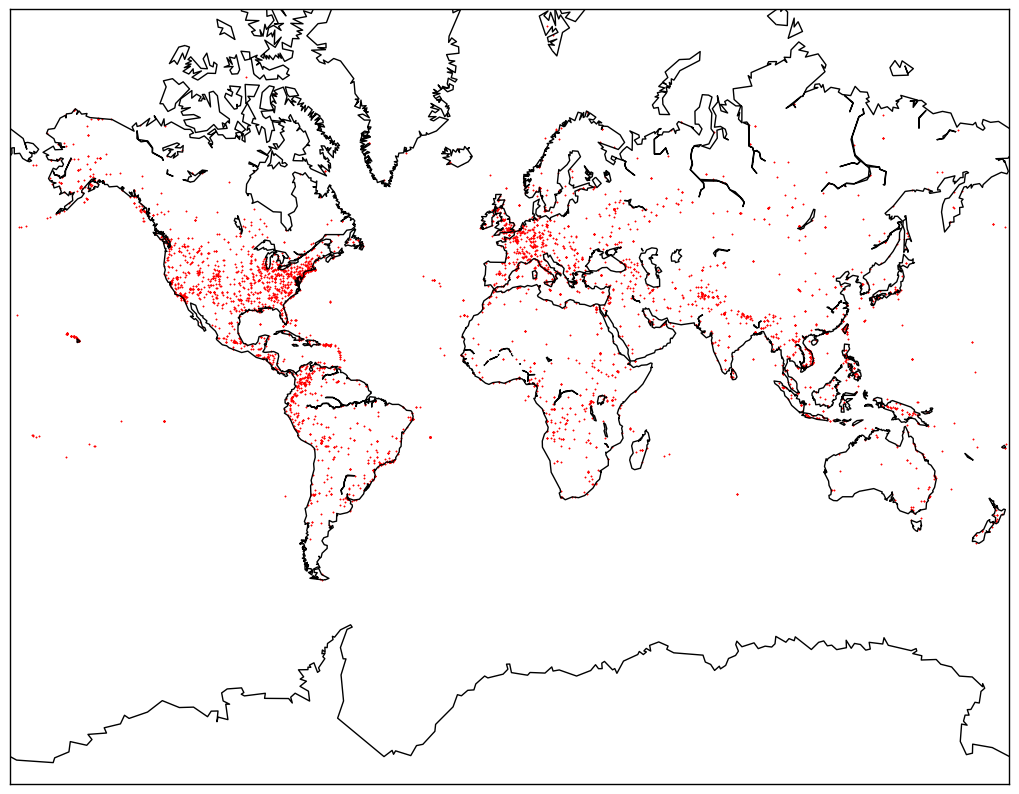

In [227]:
dff = df_all.copy()
basemap_crash(dff)


Base map for crashes from 1996 to 2016 where  Fatalities >=10


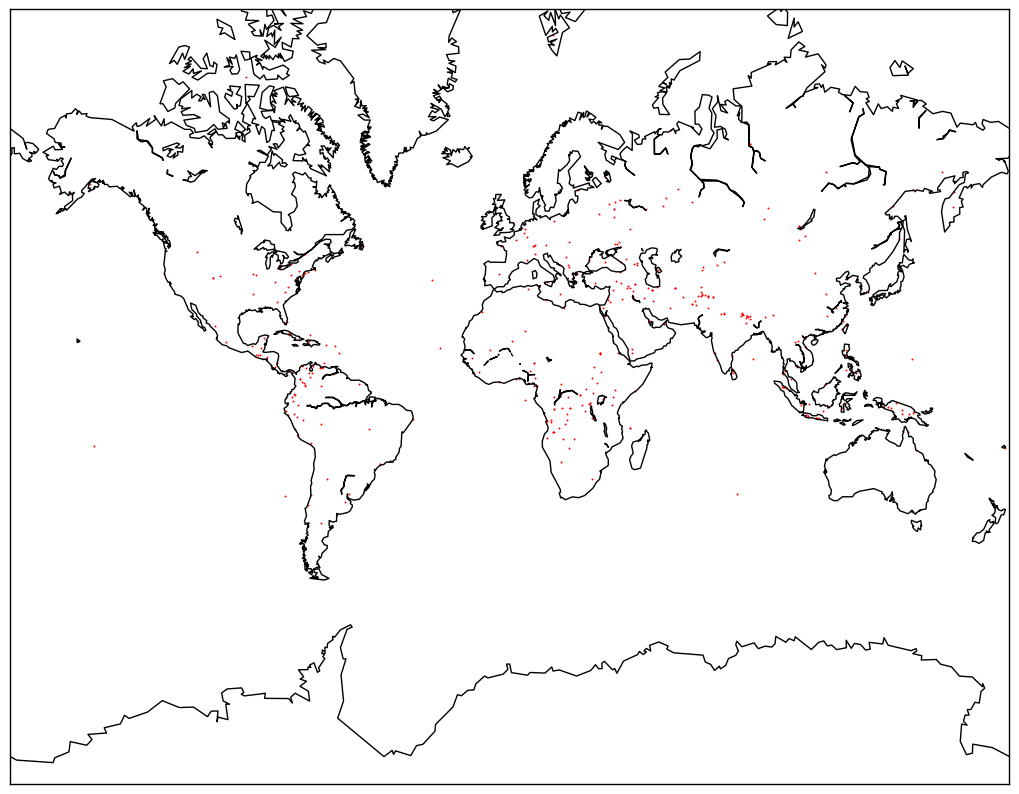

In [229]:
dff = df_all[(df_all['Year']>=1996) & (df_all['Fatalities_num']>=10)]
print "Base map for crashes from 1996 to 2016 where  Fatalities >=10"
basemap_crash(dff)

## 6.6 Interpretation of findings & relation to goals/success metrics

The success metrics was accuracy score, ROC curve, Precision-recall metrics were explained in the above and visualised as well in 5.8 and 4.8